# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [0]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session



## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting .\mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting .\mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting .\mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting .\mnist/t10k-labels-idx1-ubyte.gz


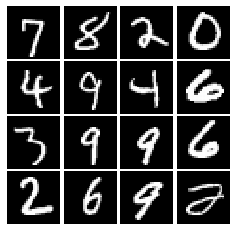

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('.\\mnist', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [0]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(x, alpha*x)
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))
        
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_uniform(shape=(batch_size,dim),minval=-1,maxval=1)     
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
        
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        fc1 = tf.layers.dense(inputs=x, units=256 , activation= lambda x: tf.nn.leaky_relu(x,0.01) ,name='fc1')
        fc2 = tf.layers.dense(inputs=fc1, units=256 , activation=lambda x: tf.nn.leaky_relu(x,0.01) ,name='fc2')
        fc3 = tf.layers.dense(inputs=fc2, units=1, activation=None  ,name='fc3')
        logits = fc3
        return logits
      
def test_discriminator(true_count=267009,flag=None):
    tf.reset_default_graph()
    with get_session() as sess:

        if flag =='DCGAN':
            y = discriminator_DCGAN(tf.ones((2, 784)))
        elif flag=='WGAN':
            y = discriminator_WGAN(tf.ones((2, 784)))
        else:
            y = discriminator(tf.ones((2, 784)))
        
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        fc1 = tf.layers.dense(inputs=z, units=1024 , activation= tf.nn.relu ,name='fc1')
        fc2 = tf.layers.dense(inputs=fc1, units=1024 , activation= tf.nn.relu ,name='fc2')
        fc3 = tf.layers.dense(inputs=fc1, units=784 , activation= tf.nn.tanh ,name='fc3')
        img = fc3
        return img
            
def test_generator(true_count=1858320,flag=None):
    tf.reset_default_graph()
    with get_session() as sess:

        if flag == 'DCGAN':
            y = generator_DCGAN(tf.ones((1, 4)))
        else:
            y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')            
            
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real,labels=tf.ones_like(logits_real)))
    D_loss += tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.zeros_like(logits_real)))
    G_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.ones_like(logits_fake)))
    return D_loss, G_loss
  
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))  

# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1)
    return D_solver, G_solver  
  
  

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

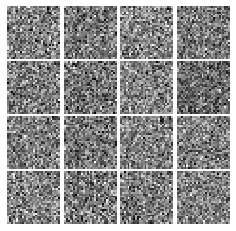


Iter: 0/4296, D: 1.959, G:0.7722
Iter: 50/4296, D: 0.1188, G:4.051
Iter: 100/4296, D: 1.312, G:0.1328
Iter: 150/4296, D: 0.3827, G:2.971
Iter: 200/4296, D: 0.699, G:0.6837


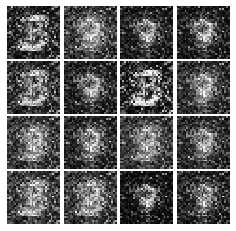


Iter: 250/4296, D: 1.027, G:0.2866
Iter: 300/4296, D: 0.7884, G:2.898
Iter: 350/4296, D: 0.6188, G:1.758
Iter: 400/4296, D: 0.9752, G:1.26
Iter: 450/4296, D: 1.481, G:0.9376


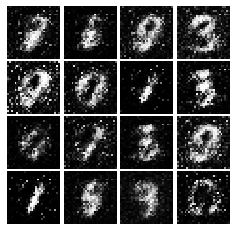


Iter: 500/4296, D: 0.8627, G:1.173
Iter: 550/4296, D: 0.7506, G:1.533
Iter: 600/4296, D: 0.9722, G:1.117
Iter: 650/4296, D: 0.6871, G:3.056
Iter: 700/4296, D: 1.182, G:1.537


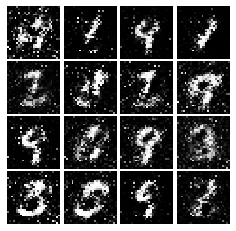


Iter: 750/4296, D: 0.9414, G:1.205
Iter: 800/4296, D: 0.943, G:1.577
Iter: 850/4296, D: 1.093, G:1.183
Iter: 900/4296, D: 1.221, G:1.997
Iter: 950/4296, D: 1.035, G:1.404


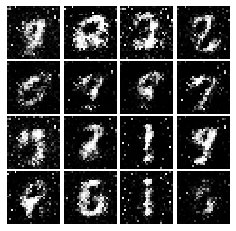


Iter: 1000/4296, D: 1.061, G:1.313
Iter: 1050/4296, D: 1.13, G:1.162
Iter: 1100/4296, D: 1.091, G:1.028
Iter: 1150/4296, D: 1.11, G:1.304
Iter: 1200/4296, D: 1.125, G:1.02


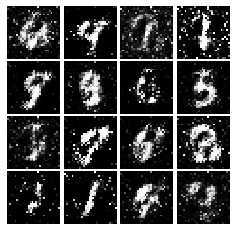


Iter: 1250/4296, D: 1.067, G:1.058
Iter: 1300/4296, D: 1.095, G:1.018
Iter: 1350/4296, D: 1.083, G:0.9942
Iter: 1400/4296, D: 1.067, G:1.335
Iter: 1450/4296, D: 1.143, G:1.102


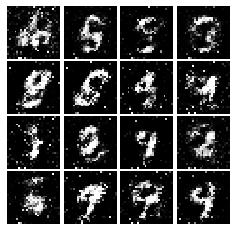


Iter: 1500/4296, D: 1.07, G:1.211
Iter: 1550/4296, D: 1.082, G:1.121
Iter: 1600/4296, D: 1.056, G:1.091
Iter: 1650/4296, D: 1.171, G:0.9805
Iter: 1700/4296, D: 1.032, G:1.216


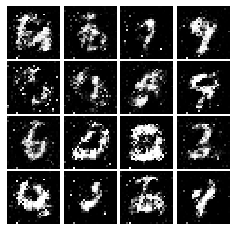


Iter: 1750/4296, D: 1.204, G:0.8814
Iter: 1800/4296, D: 1.038, G:1.103
Iter: 1850/4296, D: 1.005, G:1.107
Iter: 1900/4296, D: 1.12, G:1.288
Iter: 1950/4296, D: 1.091, G:1.237


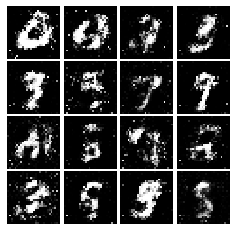


Iter: 2000/4296, D: 1.031, G:1.137
Iter: 2050/4296, D: 1.059, G:1.053
Iter: 2100/4296, D: 1.022, G:1.281
Iter: 2150/4296, D: 1.014, G:1.255
Iter: 2200/4296, D: 1.176, G:1.612


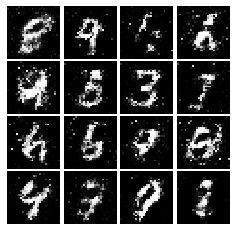


Iter: 2250/4296, D: 1.072, G:1.097
Iter: 2300/4296, D: 1.157, G:1.495
Iter: 2350/4296, D: 1.013, G:1.353
Iter: 2400/4296, D: 1.0, G:1.256
Iter: 2450/4296, D: 1.009, G:1.319


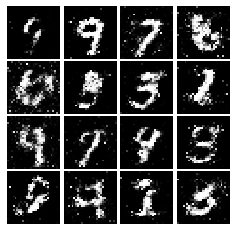


Iter: 2500/4296, D: 1.009, G:1.337
Iter: 2550/4296, D: 1.171, G:1.144
Iter: 2600/4296, D: 1.14, G:1.032
Iter: 2650/4296, D: 1.077, G:1.508
Iter: 2700/4296, D: 0.9983, G:1.202


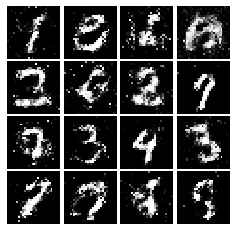


Iter: 2750/4296, D: 1.097, G:1.374
Iter: 2800/4296, D: 1.089, G:1.252
Iter: 2850/4296, D: 0.9788, G:1.203
Iter: 2900/4296, D: 1.005, G:1.176
Iter: 2950/4296, D: 1.077, G:1.469


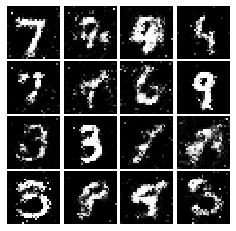


Iter: 3000/4296, D: 1.059, G:1.231
Iter: 3050/4296, D: 0.9941, G:1.525
Iter: 3100/4296, D: 0.9407, G:1.299
Iter: 3150/4296, D: 1.014, G:1.214
Iter: 3200/4296, D: 1.103, G:1.61


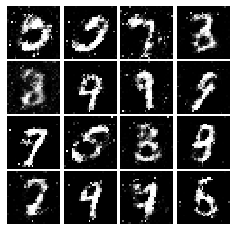


Iter: 3250/4296, D: 1.032, G:1.307
Iter: 3300/4296, D: 1.109, G:1.331
Iter: 3350/4296, D: 1.077, G:1.271
Iter: 3400/4296, D: 0.958, G:1.094
Iter: 3450/4296, D: 1.029, G:1.211


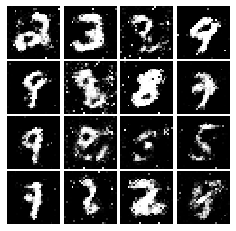


Iter: 3500/4296, D: 0.9661, G:1.315
Iter: 3550/4296, D: 0.9634, G:1.36
Iter: 3600/4296, D: 0.9659, G:1.287
Iter: 3650/4296, D: 0.9609, G:1.354
Iter: 3700/4296, D: 0.9862, G:1.249


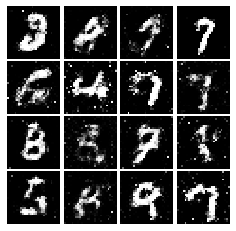


Iter: 3750/4296, D: 1.036, G:1.321
Iter: 3800/4296, D: 1.106, G:1.219
Iter: 3850/4296, D: 0.8786, G:1.214
Iter: 3900/4296, D: 0.8677, G:1.624
Iter: 3950/4296, D: 1.05, G:1.575


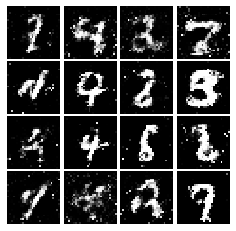


Iter: 4000/4296, D: 1.006, G:1.388
Iter: 4050/4296, D: 0.9083, G:1.367
Iter: 4100/4296, D: 0.9988, G:0.9915
Iter: 4150/4296, D: 0.8921, G:1.293
Iter: 4200/4296, D: 0.8235, G:1.476


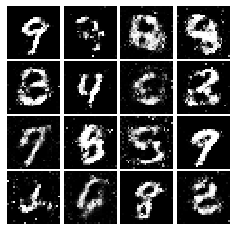


Iter: 4250/4296, D: 1.04, G:1.552
Final images


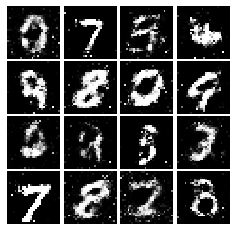

In [9]:
#@title
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 
# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}/{}, D: {:.4}, G:{:.4}'.format(it,max_iter,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()


with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

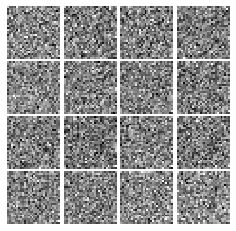


Iter: 0/4296, D: 1.81, G:0.4552
Iter: 50/4296, D: 0.1419, G:1.823
Iter: 100/4296, D: 0.1192, G:0.1588
Iter: 150/4296, D: 0.08488, G:0.4092
Iter: 200/4296, D: 0.06896, G:0.3601


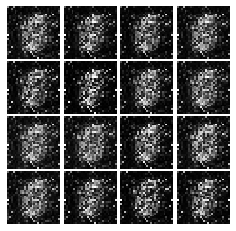


Iter: 250/4296, D: 0.3202, G:0.6003
Iter: 300/4296, D: 0.2146, G:0.7296
Iter: 350/4296, D: 0.1405, G:0.3916
Iter: 400/4296, D: 0.1261, G:0.3241
Iter: 450/4296, D: 0.1322, G:0.2392


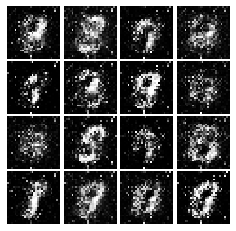


Iter: 500/4296, D: 0.1676, G:0.2348
Iter: 550/4296, D: 0.1642, G:0.3128
Iter: 600/4296, D: 0.1476, G:0.3536
Iter: 650/4296, D: 0.1296, G:0.4588
Iter: 700/4296, D: 0.1546, G:0.2345


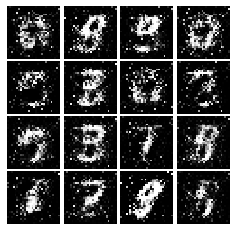


Iter: 750/4296, D: 0.1688, G:0.3819
Iter: 800/4296, D: 0.1202, G:0.2518
Iter: 850/4296, D: 0.1537, G:0.1327
Iter: 900/4296, D: 0.1414, G:0.2597
Iter: 950/4296, D: 0.1499, G:0.2489


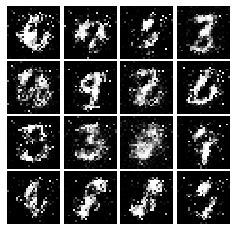


Iter: 1000/4296, D: 0.163, G:0.1861
Iter: 1050/4296, D: 0.1641, G:0.1383
Iter: 1100/4296, D: 0.2599, G:0.2776
Iter: 1150/4296, D: 0.1686, G:0.2067
Iter: 1200/4296, D: 0.1975, G:0.2478


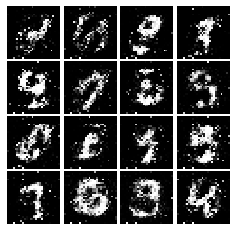


Iter: 1250/4296, D: 0.1544, G:0.245
Iter: 1300/4296, D: 0.1208, G:0.357
Iter: 1350/4296, D: 0.1424, G:0.2841
Iter: 1400/4296, D: 0.1457, G:0.2746
Iter: 1450/4296, D: 0.1611, G:0.3075


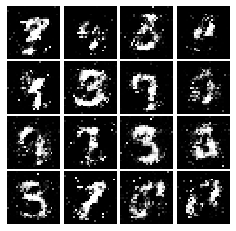


Iter: 1500/4296, D: 0.1809, G:0.1996
Iter: 1550/4296, D: 0.1521, G:0.208
Iter: 1600/4296, D: 0.1804, G:0.2181
Iter: 1650/4296, D: 0.1676, G:0.2587
Iter: 1700/4296, D: 0.1671, G:0.2466


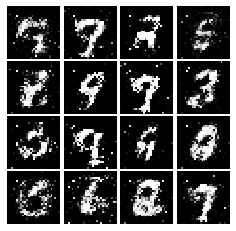


Iter: 1750/4296, D: 0.1707, G:0.292
Iter: 1800/4296, D: 0.1559, G:0.2523
Iter: 1850/4296, D: 0.1392, G:0.2546
Iter: 1900/4296, D: 0.1542, G:0.2994
Iter: 1950/4296, D: 0.1639, G:0.3509


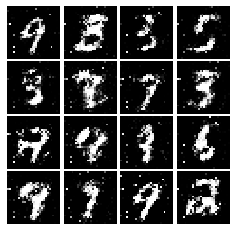


Iter: 2000/4296, D: 0.1452, G:0.2368
Iter: 2050/4296, D: 0.1696, G:0.2273
Iter: 2100/4296, D: 0.1759, G:0.2493
Iter: 2150/4296, D: 0.1612, G:0.2748
Iter: 2200/4296, D: 0.1613, G:0.2482


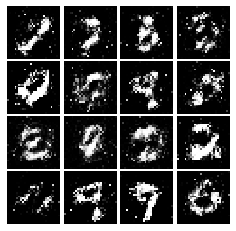


Iter: 2250/4296, D: 0.1546, G:0.2459
Iter: 2300/4296, D: 0.1632, G:0.2489
Iter: 2350/4296, D: 0.1506, G:0.2783
Iter: 2400/4296, D: 0.1733, G:0.2574
Iter: 2450/4296, D: 0.1761, G:0.2411


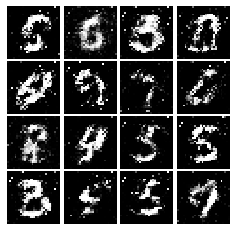


Iter: 2500/4296, D: 0.1383, G:0.224
Iter: 2550/4296, D: 0.1502, G:0.2873
Iter: 2600/4296, D: 0.156, G:0.2486
Iter: 2650/4296, D: 0.1523, G:0.2408
Iter: 2700/4296, D: 0.1936, G:0.2523


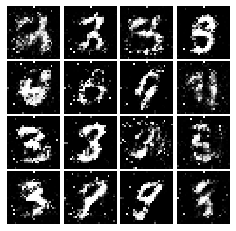


Iter: 2750/4296, D: 0.1848, G:0.2458
Iter: 2800/4296, D: 0.158, G:0.268
Iter: 2850/4296, D: 0.1457, G:0.2825
Iter: 2900/4296, D: 0.1665, G:0.2338
Iter: 2950/4296, D: 0.1594, G:0.2121


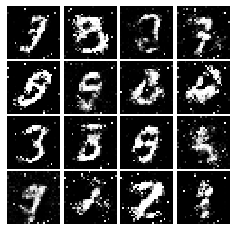


Iter: 3000/4296, D: 0.1584, G:0.2726
Iter: 3050/4296, D: 0.1632, G:0.3149
Iter: 3100/4296, D: 0.1848, G:0.2623
Iter: 3150/4296, D: 0.1672, G:0.2912
Iter: 3200/4296, D: 0.1482, G:0.2277


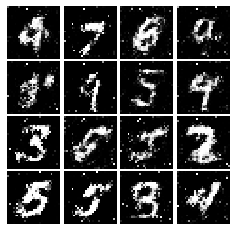


Iter: 3250/4296, D: 0.1522, G:0.2439
Iter: 3300/4296, D: 0.1676, G:0.2441
Iter: 3350/4296, D: 0.1624, G:0.2482
Iter: 3400/4296, D: 0.1586, G:0.235
Iter: 3450/4296, D: 0.1556, G:0.2752


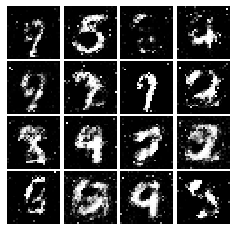


Iter: 3500/4296, D: 0.1481, G:0.2637
Iter: 3550/4296, D: 0.1605, G:0.229
Iter: 3600/4296, D: 0.1569, G:0.3221
Iter: 3650/4296, D: 0.1627, G:0.2634
Iter: 3700/4296, D: 0.1595, G:0.25


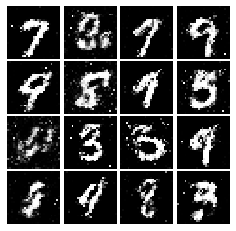


Iter: 3750/4296, D: 0.141, G:0.2391
Iter: 3800/4296, D: 0.1542, G:0.2403
Iter: 3850/4296, D: 0.1773, G:0.2502
Iter: 3900/4296, D: 0.1819, G:0.2122
Iter: 3950/4296, D: 0.1625, G:0.2078


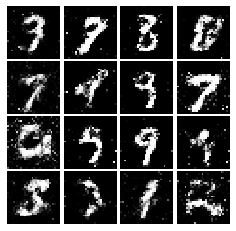


Iter: 4000/4296, D: 0.142, G:0.2352
Iter: 4050/4296, D: 0.1538, G:0.2627
Iter: 4100/4296, D: 0.137, G:0.2754
Iter: 4150/4296, D: 0.1764, G:0.2449
Iter: 4200/4296, D: 0.1678, G:0.2218


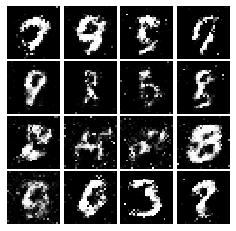


Iter: 4250/4296, D: 0.1534, G:0.2311
Final images


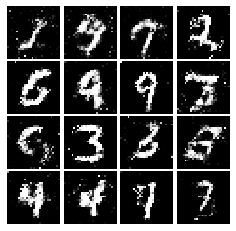

In [10]:
#####           LSGAN

def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}/{}, D: {:.4}, G:{:.4}'.format(it,max_iter,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()


def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = tf.reduce_mean( 0.5*tf.square( score_real -1.0 ) + 0.5*tf.square( score_fake )  )
    G_loss = tf.reduce_mean( 0.5*tf.square(score_fake - 1.0))
    return D_loss, G_loss
  
  
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))
    
    
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)


with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)
  

We have to recreate our network since we've changed our functions.

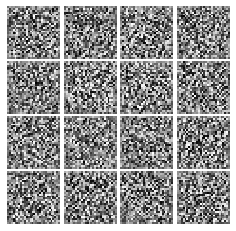


Iter: 0/4296, D: 1.352, G:0.5856
Iter: 50/4296, D: 0.49, G:2.062
Iter: 100/4296, D: 0.9946, G:0.912
Iter: 150/4296, D: 0.8264, G:1.233
Iter: 200/4296, D: 1.117, G:0.9983


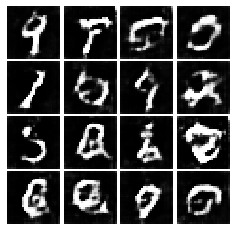


Iter: 250/4296, D: 1.237, G:1.589
Iter: 300/4296, D: 1.115, G:0.8022
Iter: 350/4296, D: 1.131, G:0.5577
Iter: 400/4296, D: 1.155, G:1.072
Iter: 450/4296, D: 1.135, G:0.9832


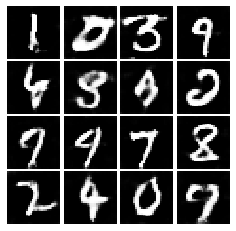


Iter: 500/4296, D: 1.194, G:1.017
Iter: 550/4296, D: 1.124, G:0.9023
Iter: 600/4296, D: 1.125, G:0.9244
Iter: 650/4296, D: 1.109, G:0.8629
Iter: 700/4296, D: 1.286, G:0.9524


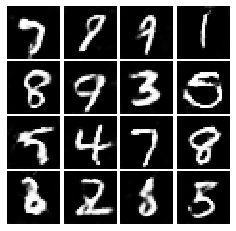


Iter: 750/4296, D: 1.247, G:1.802
Iter: 800/4296, D: 1.199, G:1.132
Iter: 850/4296, D: 1.17, G:1.065
Iter: 900/4296, D: 1.128, G:0.8035
Iter: 950/4296, D: 1.59, G:1.147


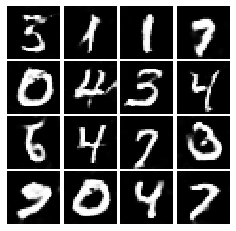


Iter: 1000/4296, D: 1.246, G:0.6696
Iter: 1050/4296, D: 1.163, G:0.7534
Iter: 1100/4296, D: 1.214, G:1.062
Iter: 1150/4296, D: 1.231, G:0.9341
Iter: 1200/4296, D: 1.183, G:0.6158


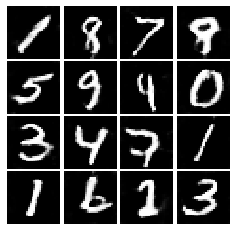


Iter: 1250/4296, D: 1.177, G:0.8807
Iter: 1300/4296, D: 1.306, G:1.64
Iter: 1350/4296, D: 1.118, G:0.7063
Iter: 1400/4296, D: 1.126, G:1.109
Iter: 1450/4296, D: 1.09, G:0.9554


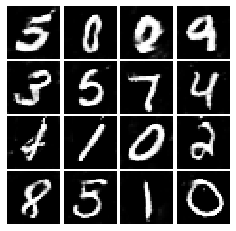


Iter: 1500/4296, D: 1.078, G:1.288
Iter: 1550/4296, D: 1.118, G:0.9326
Iter: 1600/4296, D: 1.179, G:1.336
Iter: 1650/4296, D: 1.273, G:0.7963
Iter: 1700/4296, D: 1.16, G:0.8008


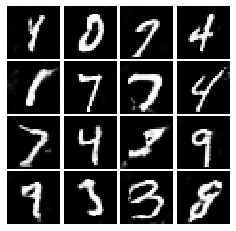


Iter: 1750/4296, D: 1.108, G:0.952
Iter: 1800/4296, D: 1.111, G:0.9294
Iter: 1850/4296, D: 1.129, G:1.141
Iter: 1900/4296, D: 1.138, G:1.592
Iter: 1950/4296, D: 1.246, G:0.9481


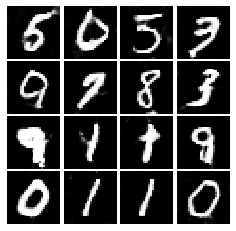


Iter: 2000/4296, D: 1.076, G:0.7994
Iter: 2050/4296, D: 1.035, G:1.075
Iter: 2100/4296, D: 1.129, G:1.167
Iter: 2150/4296, D: 1.035, G:0.9299
Iter: 2200/4296, D: 1.002, G:1.251


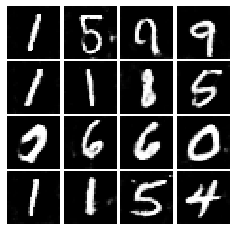


Iter: 2250/4296, D: 1.011, G:1.814
Iter: 2300/4296, D: 1.1, G:1.6
Iter: 2350/4296, D: 1.055, G:1.273
Iter: 2400/4296, D: 1.096, G:1.082
Iter: 2450/4296, D: 1.136, G:1.333


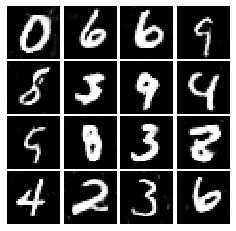


Iter: 2500/4296, D: 1.04, G:1.689
Iter: 2550/4296, D: 0.9751, G:1.017
Iter: 2600/4296, D: 1.032, G:1.093
Iter: 2650/4296, D: 1.023, G:0.7008
Iter: 2700/4296, D: 1.132, G:0.8891


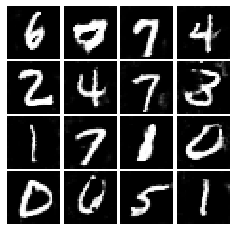


Iter: 2750/4296, D: 0.9956, G:0.7971
Iter: 2800/4296, D: 0.976, G:0.9505
Iter: 2850/4296, D: 1.024, G:1.027
Iter: 2900/4296, D: 0.9986, G:1.2
Iter: 2950/4296, D: 0.9529, G:1.744


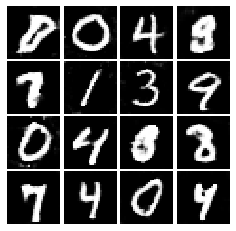


Iter: 3000/4296, D: 0.9088, G:1.171
Iter: 3050/4296, D: 1.125, G:0.7908
Iter: 3100/4296, D: 1.014, G:1.474
Iter: 3150/4296, D: 1.116, G:0.5511
Iter: 3200/4296, D: 1.11, G:1.15


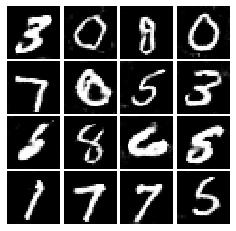


Iter: 3250/4296, D: 0.9229, G:1.589
Iter: 3300/4296, D: 1.001, G:1.618
Iter: 3350/4296, D: 0.9258, G:1.536
Iter: 3400/4296, D: 0.9368, G:1.376
Iter: 3450/4296, D: 0.8978, G:1.67


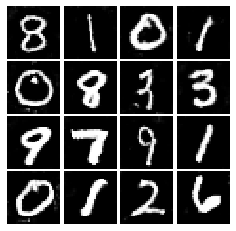


Iter: 3500/4296, D: 0.9012, G:0.9595
Iter: 3550/4296, D: 1.0, G:1.106
Iter: 3600/4296, D: 0.9996, G:0.3811
Iter: 3650/4296, D: 0.948, G:1.369
Iter: 3700/4296, D: 1.126, G:0.9896


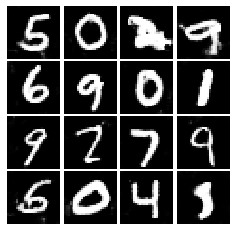


Iter: 3750/4296, D: 0.884, G:1.207
Iter: 3800/4296, D: 0.8762, G:1.411
Iter: 3850/4296, D: 0.8692, G:1.473
Iter: 3900/4296, D: 1.003, G:0.9813
Iter: 3950/4296, D: 1.2, G:2.727


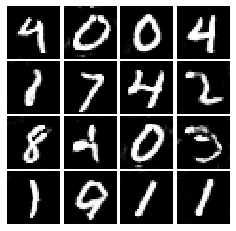


Iter: 4000/4296, D: 0.8001, G:1.262
Iter: 4050/4296, D: 0.8095, G:1.47
Iter: 4100/4296, D: 1.048, G:1.257
Iter: 4150/4296, D: 0.9076, G:1.69
Iter: 4200/4296, D: 0.7808, G:1.596


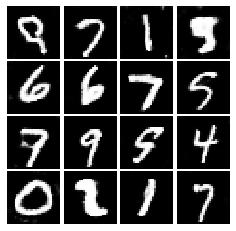


Iter: 4250/4296, D: 0.9206, G:1.366
Final images


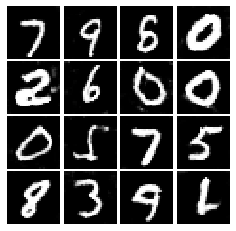

In [11]:
#####   DCGAN

def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}/{}, D: {:.4}, G:{:.4}'.format(it,max_iter,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()


def discriminator_DCGAN(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        x = tf.reshape(x,[-1,28,28,1])
        conv1_1 = tf.layers.conv2d(x, filters=32, padding='VALID', kernel_size=5, strides=1,
                                   activation=lambda x: tf.nn.leaky_relu(x,0.01), name = 'conv1_1')
        pool1_2 = tf.layers.max_pooling2d(conv1_1, pool_size=2, strides=2, padding='SAME', name='pool1_2')
        conv2_1 = tf.layers.conv2d(pool1_2, filters=64, padding='VALID', kernel_size=5, strides=1,
                                   activation=lambda x: tf.nn.leaky_relu(x,0.01), name = 'conv2_1')
        pool2_2 = tf.layers.max_pooling2d(conv2_1, pool_size=2, strides=2, padding='SAME', name='pool2_2') 
          
        flatten = tf.contrib.layers.flatten(pool2_2)
        fc3 = tf.layers.dense(flatten, units=4*4*64 , activation= lambda x: tf.nn.leaky_relu(x,0.01) ,name='fc3')
        fc4 = tf.layers.dense(fc3, units=1 , activation= None ,name='fc4')
        logits = fc4
        return logits

def generator_DCGAN(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        fc1 = tf.layers.dense(z, units=1024 , activation=tf.nn.relu ,name='fc1')
        bn2 =  tf.layers.batch_normalization(fc1, training=True,name='bn2')
        fc3 = tf.layers.dense(bn2, units=7*7*128 , activation=tf.nn.relu ,name='fc3')
        bn4 =  tf.layers.batch_normalization(fc3, training=True,name='bn4')
        to_img =  tf.reshape(bn4,[-1,7,7,128])
        deconv5 = tf.layers.conv2d_transpose(to_img,padding='SAME',filters=64,kernel_size=4, strides=2,
                                             activation=tf.nn.relu,name='deconv5')
        bn6 =  tf.layers.batch_normalization(deconv5, training=True,name='bn6')
        deconv7 = tf.layers.conv2d_transpose(bn6,padding='SAME',filters=1,kernel_size=4, strides=2,
                                             activation=tf.nn.tanh,name='deconv7')        
        img = deconv7
        return img      
    
    
    
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator_DCGAN(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator_DCGAN(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator_DCGAN(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=10)

------

# Extra Credit 
** Be sure you don't destroy your results above, but feel free to copy+paste code to get results below **
* For a small amount of extra credit, you can implement additional new GAN loss functions below, provided they converge. See AFI, BiGAN, Softmax GAN, Conditional GAN, InfoGAN, etc. They should converge to get credit.
* Likewise for an improved architecture or using a convolutional GAN (or even implement a VAE)
* For a bigger chunk of extra credit, load the CIFAR10 data (see last assignment) and train a compelling generative model on CIFAR-10
* Demonstrate the value of GANs in building semi-supervised models. In a semi-supervised example, only some fraction of the input data has labels; we can supervise this in MNIST by only training on a few dozen or hundred labeled examples. This was first described in [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498).
* Something new/cool.

#### Describe what you did here

# WGAN-GP (Small Extra Credit)

Please only attempt after you have completed everything above.

We'll now look at [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) as a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement Algorithm 1 in the paper. 

You'll also need to use a discriminator and corresponding generator without max-pooling. So we cannot use the one we currently have from DCGAN. Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (We don't use Q, simply implement the network up to D). You're also welcome to define a new generator and discriminator in this notebook, in case you want to use the fully-connected pair of D(x) and G(z) you used at the top of this notebook.

Architecture:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

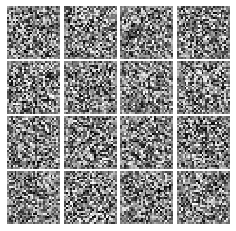


Iter: 0/17187, D: -71.42, G:-7.307, time:5.5885539054870605 sec)
Iter: 20/17187, D: -524.8, G:-257.2, time:87.98121380805969 sec)
Iter: 40/17187, D: 347.6, G:-620.2, time:108.16498827934265 sec)
Iter: 60/17187, D: -201.2, G:-657.4, time:112.7170238494873 sec)
Iter: 80/17187, D: 14.4, G:-281.9, time:117.27252984046936 sec)
Iter: 100/17187, D: -104.7, G:-513.8, time:121.8853907585144 sec)
Iter: 120/17187, D: -144.7, G:-499.5, time:126.45148038864136 sec)
Iter: 140/17187, D: -98.95, G:-391.7, time:130.99877285957336 sec)
Iter: 160/17187, D: -161.8, G:-515.0, time:135.61124396324158 sec)
Iter: 180/17187, D: -145.9, G:-382.0, time:140.153413772583 sec)
Iter: 200/17187, D: -147.3, G:-527.6, time:144.72408413887024 sec)
Iter: 220/17187, D: -1.694, G:-144.3, time:149.26519560813904 sec)
Iter: 240/17187, D: -3.212, G:-133.5, time:153.8802101612091 sec)


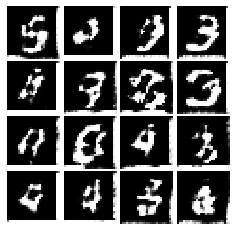


Iter: 260/17187, D: -16.5, G:-142.8, time:159.32494163513184 sec)
Iter: 280/17187, D: -130.4, G:-324.1, time:163.87761163711548 sec)
Iter: 300/17187, D: -153.7, G:-320.4, time:168.41112685203552 sec)
Iter: 320/17187, D: -150.2, G:-378.3, time:172.99295902252197 sec)
Iter: 340/17187, D: 4.323, G:-119.3, time:177.5298421382904 sec)
Iter: 360/17187, D: -5.339, G:-104.5, time:182.07145309448242 sec)
Iter: 380/17187, D: -5.469, G:-104.8, time:186.6516740322113 sec)
Iter: 400/17187, D: -6.247, G:-103.0, time:191.20803427696228 sec)
Iter: 420/17187, D: -9.403, G:-104.0, time:195.74644231796265 sec)
Iter: 440/17187, D: 1.327, G:-110.6, time:200.28314685821533 sec)
Iter: 460/17187, D: -9.161, G:-103.1, time:204.8963782787323 sec)
Iter: 480/17187, D: -9.281, G:-102.3, time:209.44284534454346 sec)


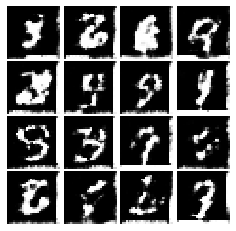


Iter: 500/17187, D: -10.35, G:-98.51, time:218.7903175354004 sec)
Iter: 520/17187, D: -8.873, G:-109.2, time:223.39791560173035 sec)
Iter: 540/17187, D: -5.991, G:-102.2, time:227.95486736297607 sec)
Iter: 560/17187, D: -8.695, G:-103.6, time:232.50271892547607 sec)
Iter: 580/17187, D: -12.91, G:-109.7, time:237.10611701011658 sec)
Iter: 600/17187, D: -12.14, G:-113.2, time:241.64554905891418 sec)
Iter: 620/17187, D: 45.75, G:-113.3, time:246.20001411437988 sec)
Iter: 640/17187, D: -32.92, G:-133.7, time:250.73122119903564 sec)
Iter: 660/17187, D: -93.41, G:-205.4, time:255.3337905406952 sec)
Iter: 680/17187, D: 1.037e+03, G:-137.9, time:259.8689148426056 sec)
Iter: 700/17187, D: -150.0, G:-324.4, time:264.42298460006714 sec)
Iter: 720/17187, D: -90.54, G:-203.6, time:269.0255410671234 sec)
Iter: 740/17187, D: -103.3, G:-324.7, time:273.5742654800415 sec)


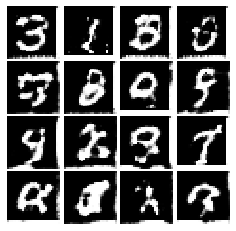


Iter: 760/17187, D: -77.78, G:-148.9, time:279.07197165489197 sec)
Iter: 780/17187, D: -112.9, G:-209.5, time:283.6104667186737 sec)
Iter: 800/17187, D: -130.9, G:-280.4, time:288.20882773399353 sec)
Iter: 820/17187, D: -114.8, G:-223.2, time:292.7743136882782 sec)
Iter: 840/17187, D: -14.66, G:-113.0, time:297.3312711715698 sec)
Iter: 860/17187, D: -99.53, G:-231.4, time:301.94232273101807 sec)
Iter: 880/17187, D: -128.3, G:-317.9, time:306.47460412979126 sec)
Iter: 900/17187, D: -139.8, G:-156.6, time:311.02234077453613 sec)
Iter: 920/17187, D: -188.4, G:-205.5, time:315.5795569419861 sec)
Iter: 940/17187, D: -121.6, G:-144.1, time:320.18737864494324 sec)
Iter: 960/17187, D: 145.3, G:-321.2, time:324.73382568359375 sec)
Iter: 980/17187, D: -78.66, G:-197.6, time:329.3087215423584 sec)


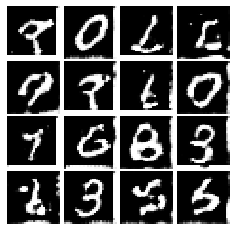


Iter: 1000/17187, D: -132.9, G:-159.6, time:338.91679191589355 sec)
Iter: 1020/17187, D: -167.0, G:-367.3, time:343.47329807281494 sec)
Iter: 1040/17187, D: -192.1, G:-305.2, time:348.04177713394165 sec)
Iter: 1060/17187, D: -99.18, G:-187.8, time:352.6554582118988 sec)
Iter: 1080/17187, D: -148.5, G:-185.1, time:357.21732807159424 sec)
Iter: 1100/17187, D: -45.86, G:-138.2, time:361.79904770851135 sec)
Iter: 1120/17187, D: -123.2, G:-255.3, time:366.3478960990906 sec)
Iter: 1140/17187, D: -125.2, G:-291.6, time:370.9714889526367 sec)
Iter: 1160/17187, D: -140.7, G:-258.9, time:375.54179286956787 sec)
Iter: 1180/17187, D: -151.9, G:-198.8, time:380.10435724258423 sec)
Iter: 1200/17187, D: -191.6, G:-415.1, time:384.67257952690125 sec)
Iter: 1220/17187, D: -133.5, G:-175.4, time:389.28036522865295 sec)
Iter: 1240/17187, D: -137.6, G:-323.4, time:393.8557152748108 sec)


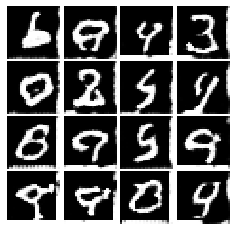


Iter: 1260/17187, D: -144.5, G:-291.0, time:399.30473232269287 sec)
Iter: 1280/17187, D: -5.186, G:-89.89, time:403.92586851119995 sec)
Iter: 1300/17187, D: -6.11, G:-95.2, time:408.48000478744507 sec)
Iter: 1320/17187, D: -9.251, G:-103.0, time:413.03007555007935 sec)
Iter: 1340/17187, D: -11.87, G:-108.5, time:417.5805494785309 sec)
Iter: 1360/17187, D: -16.43, G:-99.64, time:422.20620918273926 sec)
Iter: 1380/17187, D: -92.19, G:-242.2, time:426.7661237716675 sec)
Iter: 1400/17187, D: -107.5, G:-293.2, time:431.32913875579834 sec)
Iter: 1420/17187, D: -121.7, G:-275.6, time:435.9289894104004 sec)
Iter: 1440/17187, D: -132.1, G:-316.4, time:440.49817967414856 sec)
Iter: 1460/17187, D: -6.851, G:-95.64, time:445.0644705295563 sec)
Iter: 1480/17187, D: -6.605, G:-97.89, time:449.61712098121643 sec)


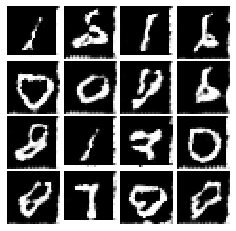


Iter: 1500/17187, D: -12.37, G:-109.1, time:459.0235207080841 sec)
Iter: 1520/17187, D: -11.85, G:-115.4, time:463.59253215789795 sec)
Iter: 1540/17187, D: -26.13, G:-107.4, time:468.1477735042572 sec)
Iter: 1560/17187, D: -120.2, G:-178.2, time:472.74711513519287 sec)
Iter: 1580/17187, D: -105.8, G:-256.2, time:477.33043575286865 sec)
Iter: 1600/17187, D: -3.573, G:-79.18, time:481.89656925201416 sec)
Iter: 1620/17187, D: -7.879, G:-91.74, time:486.5120701789856 sec)
Iter: 1640/17187, D: -9.549, G:-104.2, time:491.0719132423401 sec)
Iter: 1660/17187, D: -11.25, G:-107.0, time:495.64390206336975 sec)
Iter: 1680/17187, D: -18.33, G:-100.2, time:500.20716857910156 sec)
Iter: 1700/17187, D: -84.78, G:-219.8, time:504.8078246116638 sec)
Iter: 1720/17187, D: -105.6, G:-277.5, time:509.37574434280396 sec)
Iter: 1740/17187, D: -3.962, G:-82.25, time:513.9412899017334 sec)


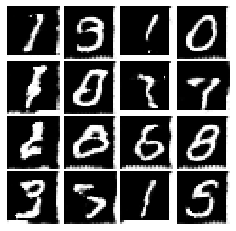


Iter: 1760/17187, D: -6.564, G:-78.7, time:519.4214675426483 sec)
Iter: 1780/17187, D: -9.269, G:-79.4, time:523.9665696620941 sec)
Iter: 1800/17187, D: -12.19, G:-79.53, time:528.5225970745087 sec)
Iter: 1820/17187, D: -15.54, G:-88.26, time:533.0757710933685 sec)
Iter: 1840/17187, D: -72.12, G:-214.5, time:537.6822414398193 sec)
Iter: 1860/17187, D: -105.6, G:-200.7, time:542.250730752945 sec)
Iter: 1880/17187, D: -99.36, G:-250.0, time:546.800778388977 sec)
Iter: 1900/17187, D: -12.6, G:-68.12, time:551.3710389137268 sec)
Iter: 1920/17187, D: -64.65, G:-138.8, time:555.9819474220276 sec)
Iter: 1940/17187, D: -117.9, G:-300.5, time:560.5495939254761 sec)
Iter: 1960/17187, D: -184.7, G:-223.2, time:565.0937304496765 sec)
Iter: 1980/17187, D: -34.94, G:-133.1, time:569.7051455974579 sec)


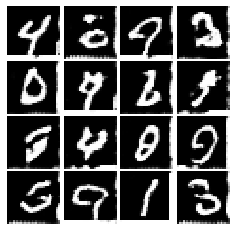


Iter: 2000/17187, D: -19.17, G:-363.4, time:579.264689207077 sec)
Iter: 2020/17187, D: -99.83, G:-225.9, time:583.8377366065979 sec)
Iter: 2040/17187, D: -175.5, G:-242.7, time:588.448844909668 sec)
Iter: 2060/17187, D: -127.2, G:-167.0, time:593.0001389980316 sec)
Iter: 2080/17187, D: -7.226, G:-97.85, time:597.5771870613098 sec)
Iter: 2100/17187, D: -13.22, G:-110.3, time:602.1301851272583 sec)
Iter: 2120/17187, D: -11.23, G:-123.8, time:606.7357175350189 sec)
Iter: 2140/17187, D: -26.46, G:-139.0, time:611.3012802600861 sec)
Iter: 2160/17187, D: -128.5, G:-285.8, time:615.8635890483856 sec)
Iter: 2180/17187, D: -104.7, G:-201.1, time:620.4739573001862 sec)
Iter: 2200/17187, D: -112.4, G:-154.1, time:625.040901184082 sec)
Iter: 2220/17187, D: -166.4, G:-273.6, time:629.5881123542786 sec)
Iter: 2240/17187, D: -144.1, G:-102.6, time:634.1678116321564 sec)


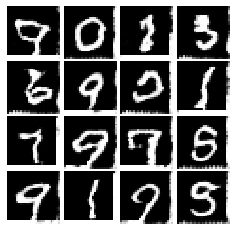


Iter: 2260/17187, D: -157.9, G:-168.8, time:639.6098258495331 sec)
Iter: 2280/17187, D: -104.0, G:-202.2, time:644.1739549636841 sec)
Iter: 2300/17187, D: -152.6, G:-212.4, time:648.7374818325043 sec)
Iter: 2320/17187, D: -30.24, G:-80.35, time:653.3314859867096 sec)
Iter: 2340/17187, D: -146.0, G:-179.8, time:657.9015188217163 sec)
Iter: 2360/17187, D: -214.4, G:-173.5, time:662.4703464508057 sec)
Iter: 2380/17187, D: -53.89, G:-124.0, time:667.0394032001495 sec)
Iter: 2400/17187, D: -118.2, G:-111.5, time:671.6501245498657 sec)
Iter: 2420/17187, D: -152.7, G:-267.9, time:676.2157325744629 sec)
Iter: 2440/17187, D: -162.6, G:-233.9, time:680.782909154892 sec)
Iter: 2460/17187, D: -178.9, G:-188.4, time:685.3913929462433 sec)
Iter: 2480/17187, D: -131.7, G:-115.9, time:689.9605481624603 sec)


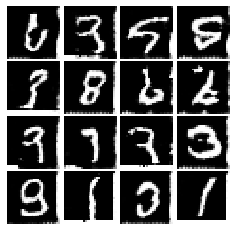


Iter: 2500/17187, D: -266.3, G:-67.17, time:699.3104600906372 sec)
Iter: 2520/17187, D: -169.6, G:-136.3, time:703.920704126358 sec)
Iter: 2540/17187, D: 3.683, G:-40.46, time:708.4848356246948 sec)
Iter: 2560/17187, D: -163.7, G:-303.6, time:713.0402736663818 sec)
Iter: 2580/17187, D: -163.3, G:-298.3, time:717.6076939105988 sec)
Iter: 2600/17187, D: -184.0, G:-117.4, time:722.2186794281006 sec)
Iter: 2620/17187, D: -180.3, G:-147.3, time:726.786123752594 sec)
Iter: 2640/17187, D: -140.5, G:-272.3, time:731.3543808460236 sec)
Iter: 2660/17187, D: -88.99, G:-144.1, time:735.9574258327484 sec)
Iter: 2680/17187, D: -98.33, G:-140.3, time:740.5127036571503 sec)
Iter: 2700/17187, D: -101.4, G:-169.2, time:745.0569679737091 sec)
Iter: 2720/17187, D: -163.4, G:-304.5, time:749.6157958507538 sec)
Iter: 2740/17187, D: -167.4, G:-183.7, time:754.2294812202454 sec)


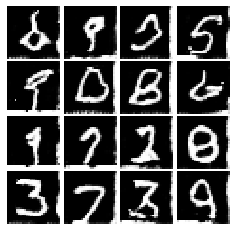


Iter: 2760/17187, D: 1.025e+04, G:-250.8, time:759.6501548290253 sec)
Iter: 2780/17187, D: -120.7, G:-293.0, time:764.1989448070526 sec)
Iter: 2800/17187, D: -103.2, G:-161.3, time:768.7558751106262 sec)
Iter: 2820/17187, D: -150.0, G:-128.9, time:773.353714466095 sec)
Iter: 2840/17187, D: -126.3, G:-251.2, time:777.8900971412659 sec)
Iter: 2860/17187, D: -191.0, G:-316.3, time:782.4678719043732 sec)
Iter: 2880/17187, D: -191.1, G:-292.5, time:787.0737490653992 sec)
Iter: 2900/17187, D: -138.1, G:-210.8, time:791.6183567047119 sec)
Iter: 2920/17187, D: -3.351, G:-98.91, time:796.1924586296082 sec)
Iter: 2940/17187, D: -12.57, G:-87.76, time:800.7404742240906 sec)
Iter: 2960/17187, D: -115.0, G:-359.7, time:805.3298790454865 sec)
Iter: 2980/17187, D: -146.5, G:-227.4, time:809.8870074748993 sec)


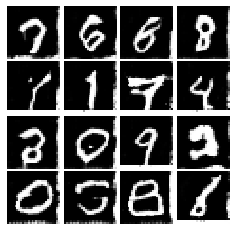


Iter: 3000/17187, D: -207.4, G:-217.5, time:819.2385942935944 sec)
Iter: 3020/17187, D: -169.1, G:-399.7, time:823.8459641933441 sec)
Iter: 3040/17187, D: -218.1, G:-267.4, time:828.4087386131287 sec)
Iter: 3060/17187, D: 9.666, G:-140.4, time:832.9404718875885 sec)
Iter: 3080/17187, D: -5.845, G:-141.8, time:837.5432980060577 sec)
Iter: 3100/17187, D: -11.85, G:-142.7, time:842.1150352954865 sec)
Iter: 3120/17187, D: -21.59, G:-163.2, time:846.6854662895203 sec)
Iter: 3140/17187, D: -49.06, G:-245.9, time:851.2556009292603 sec)
Iter: 3160/17187, D: -113.3, G:-159.1, time:855.86092877388 sec)
Iter: 3180/17187, D: -130.8, G:-239.9, time:860.4208877086639 sec)
Iter: 3200/17187, D: -27.52, G:-52.08, time:864.9819569587708 sec)
Iter: 3220/17187, D: -83.46, G:-116.8, time:869.5953438282013 sec)
Iter: 3240/17187, D: -132.8, G:-320.7, time:874.1663541793823 sec)


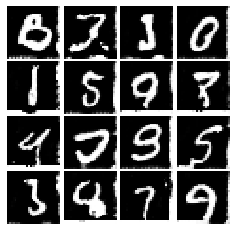


Iter: 3260/17187, D: -87.13, G:-225.0, time:879.8110001087189 sec)
Iter: 3280/17187, D: -97.49, G:-82.67, time:884.3749458789825 sec)
Iter: 3300/17187, D: -128.6, G:-118.8, time:889.0093102455139 sec)
Iter: 3320/17187, D: -132.5, G:-112.6, time:893.5677485466003 sec)
Iter: 3340/17187, D: -143.4, G:-359.0, time:898.1145663261414 sec)
Iter: 3360/17187, D: 6.997, G:-102.5, time:902.7209415435791 sec)
Iter: 3380/17187, D: 2.428, G:-108.7, time:907.286408662796 sec)
Iter: 3400/17187, D: -4.241, G:-114.8, time:911.8626980781555 sec)
Iter: 3420/17187, D: -3.65, G:-118.3, time:916.4236855506897 sec)
Iter: 3440/17187, D: -4.259, G:-119.9, time:921.0549585819244 sec)
Iter: 3460/17187, D: -6.988, G:-119.8, time:925.6140685081482 sec)
Iter: 3480/17187, D: -9.856, G:-121.2, time:930.1900525093079 sec)


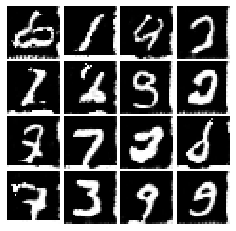


Iter: 3500/17187, D: -14.74, G:-29.47, time:939.5680906772614 sec)
Iter: 3520/17187, D: -7.78, G:-29.42, time:944.1243922710419 sec)
Iter: 3540/17187, D: -6.89, G:-40.33, time:948.7013394832611 sec)
Iter: 3560/17187, D: -13.26, G:-46.07, time:953.3017108440399 sec)
Iter: 3580/17187, D: -13.11, G:-49.37, time:957.8651614189148 sec)
Iter: 3600/17187, D: -13.57, G:-54.99, time:962.4208829402924 sec)
Iter: 3620/17187, D: -14.38, G:-53.77, time:966.9875016212463 sec)
Iter: 3640/17187, D: -19.26, G:-59.27, time:971.6041443347931 sec)
Iter: 3660/17187, D: -54.48, G:-75.84, time:976.1609015464783 sec)
Iter: 3680/17187, D: -88.62, G:-186.7, time:980.7127895355225 sec)
Iter: 3700/17187, D: -22.13, G:-125.6, time:985.2671954631805 sec)
Iter: 3720/17187, D: -103.9, G:-197.6, time:989.8718609809875 sec)
Iter: 3740/17187, D: 3.491, G:-67.82, time:994.4369790554047 sec)


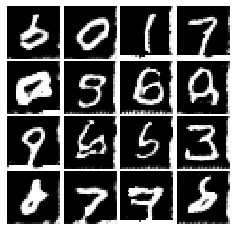


Iter: 3760/17187, D: -74.68, G:-105.3, time:999.8821833133698 sec)
Iter: 3780/17187, D: -79.83, G:-184.9, time:1004.4928529262543 sec)
Iter: 3800/17187, D: -100.2, G:-142.5, time:1009.0490067005157 sec)
Iter: 3820/17187, D: -7.325, G:-80.39, time:1013.5968501567841 sec)
Iter: 3840/17187, D: -77.61, G:-35.99, time:1018.1624293327332 sec)
Iter: 3860/17187, D: -115.7, G:-252.0, time:1022.77081990242 sec)
Iter: 3880/17187, D: -114.0, G:-170.0, time:1027.3282988071442 sec)
Iter: 3900/17187, D: -100.7, G:-223.6, time:1031.8881604671478 sec)
Iter: 3920/17187, D: -90.4, G:-140.4, time:1036.502543926239 sec)
Iter: 3940/17187, D: -71.21, G:-170.9, time:1041.0708725452423 sec)
Iter: 3960/17187, D: -103.1, G:-370.5, time:1045.642651796341 sec)
Iter: 3980/17187, D: 98.62, G:-70.63, time:1050.1944296360016 sec)


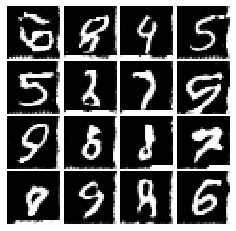


Iter: 4000/17187, D: -120.5, G:-200.1, time:1059.6131687164307 sec)
Iter: 4020/17187, D: -249.4, G:-16.24, time:1064.1705029010773 sec)
Iter: 4040/17187, D: 6.801, G:-82.14, time:1068.7296307086945 sec)
Iter: 4060/17187, D: -5.143, G:-67.46, time:1073.3150129318237 sec)
Iter: 4080/17187, D: -3.407, G:-64.7, time:1077.8923840522766 sec)
Iter: 4100/17187, D: -4.296, G:-62.51, time:1082.4575855731964 sec)
Iter: 4120/17187, D: -8.831, G:-63.86, time:1087.08074092865 sec)
Iter: 4140/17187, D: -15.04, G:-57.89, time:1091.6432926654816 sec)
Iter: 4160/17187, D: -19.35, G:-74.08, time:1096.1975116729736 sec)
Iter: 4180/17187, D: -72.1, G:-84.54, time:1100.754306793213 sec)
Iter: 4200/17187, D: -74.0, G:-148.6, time:1105.3840248584747 sec)
Iter: 4220/17187, D: -115.5, G:-193.6, time:1109.9441299438477 sec)
Iter: 4240/17187, D: -134.2, G:-238.3, time:1114.4953496456146 sec)


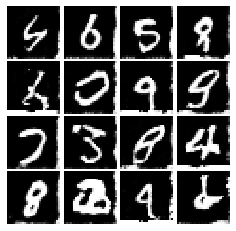


Iter: 4260/17187, D: -75.75, G:-148.2, time:1120.1576600074768 sec)
Iter: 4280/17187, D: -81.64, G:-268.5, time:1124.7043299674988 sec)
Iter: 4300/17187, D: -105.2, G:-271.7, time:1129.2538216114044 sec)
Iter: 4320/17187, D: -172.3, G:-343.4, time:1133.7981340885162 sec)
Iter: 4340/17187, D: -3.821, G:-64.99, time:1138.4173505306244 sec)
Iter: 4360/17187, D: -4.196, G:-65.45, time:1142.9880442619324 sec)
Iter: 4380/17187, D: -33.18, G:-136.5, time:1147.5487382411957 sec)
Iter: 4400/17187, D: -64.68, G:-80.29, time:1152.1152794361115 sec)
Iter: 4420/17187, D: -62.9, G:-64.25, time:1156.7358982563019 sec)
Iter: 4440/17187, D: -74.22, G:-191.6, time:1161.306043624878 sec)
Iter: 4460/17187, D: -116.2, G:-186.2, time:1165.8673810958862 sec)
Iter: 4480/17187, D: -169.7, G:-340.1, time:1170.4699566364288 sec)


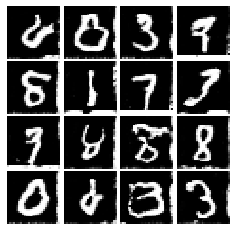


Iter: 4500/17187, D: 15.29, G:-58.42, time:1179.7926070690155 sec)
Iter: 4520/17187, D: 6.322, G:-33.19, time:1184.3415172100067 sec)
Iter: 4540/17187, D: -2.326, G:-26.81, time:1188.9555640220642 sec)
Iter: 4560/17187, D: -1.728, G:-23.15, time:1193.5123398303986 sec)
Iter: 4580/17187, D: -2.952, G:-20.95, time:1198.0815272331238 sec)
Iter: 4600/17187, D: -3.4, G:-20.47, time:1202.630994796753 sec)
Iter: 4620/17187, D: -3.891, G:-19.61, time:1207.226821422577 sec)
Iter: 4640/17187, D: -8.27, G:-17.97, time:1211.7859663963318 sec)
Iter: 4660/17187, D: -7.928, G:-20.53, time:1216.3530097007751 sec)
Iter: 4680/17187, D: -16.2, G:-20.96, time:1220.9694952964783 sec)
Iter: 4700/17187, D: -11.18, G:-21.66, time:1225.5381338596344 sec)
Iter: 4720/17187, D: -7.611, G:-23.64, time:1230.0869064331055 sec)
Iter: 4740/17187, D: -10.03, G:-22.97, time:1234.6443033218384 sec)


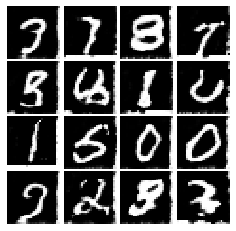


Iter: 4760/17187, D: -12.5, G:-29.29, time:1240.105869293213 sec)
Iter: 4780/17187, D: -11.62, G:-21.08, time:1244.6394605636597 sec)
Iter: 4800/17187, D: -20.04, G:-28.52, time:1249.1428544521332 sec)
Iter: 4820/17187, D: 1.345, G:-27.25, time:1253.7038006782532 sec)
Iter: 4840/17187, D: -0.3796, G:-18.02, time:1258.226397037506 sec)
Iter: 4860/17187, D: -2.479, G:-7.949, time:1262.7486999034882 sec)
Iter: 4880/17187, D: -1.353, G:-6.635, time:1267.2725052833557 sec)
Iter: 4900/17187, D: -2.242, G:-1.808, time:1271.8365132808685 sec)
Iter: 4920/17187, D: -1.609, G:3.179, time:1276.3535597324371 sec)
Iter: 4940/17187, D: -2.904, G:5.462, time:1280.8699774742126 sec)
Iter: 4960/17187, D: -2.582, G:6.497, time:1285.4436576366425 sec)
Iter: 4980/17187, D: -3.542, G:8.793, time:1289.9532978534698 sec)


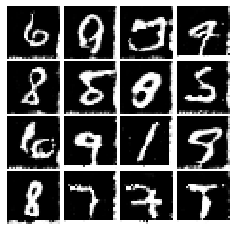


Iter: 5000/17187, D: -3.803, G:11.15, time:1299.2283642292023 sec)
Iter: 5020/17187, D: -3.046, G:15.02, time:1303.8006546497345 sec)
Iter: 5040/17187, D: -4.484, G:16.44, time:1308.3465864658356 sec)
Iter: 5060/17187, D: -4.139, G:16.57, time:1312.8814895153046 sec)
Iter: 5080/17187, D: -3.628, G:17.07, time:1317.412608385086 sec)
Iter: 5100/17187, D: -3.951, G:17.75, time:1322.0096187591553 sec)
Iter: 5120/17187, D: -5.551, G:18.29, time:1326.5395424365997 sec)
Iter: 5140/17187, D: -4.328, G:20.27, time:1331.0820598602295 sec)
Iter: 5160/17187, D: -5.267, G:19.89, time:1335.6419007778168 sec)
Iter: 5180/17187, D: -1.843, G:-16.76, time:1340.1987726688385 sec)
Iter: 5200/17187, D: -3.761, G:-14.83, time:1344.7240478992462 sec)
Iter: 5220/17187, D: -3.748, G:-12.81, time:1349.2497816085815 sec)
Iter: 5240/17187, D: -4.47, G:-13.34, time:1353.8347470760345 sec)


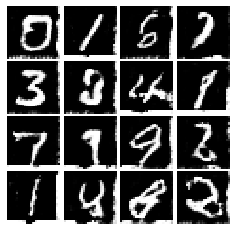


Iter: 5260/17187, D: -5.849, G:-12.35, time:1359.4124865531921 sec)
Iter: 5280/17187, D: -5.135, G:-15.16, time:1363.9393050670624 sec)
Iter: 5300/17187, D: -6.298, G:-11.62, time:1368.4687492847443 sec)
Iter: 5320/17187, D: -6.047, G:-13.57, time:1373.0612981319427 sec)
Iter: 5340/17187, D: -6.862, G:-12.65, time:1377.5966258049011 sec)
Iter: 5360/17187, D: -10.31, G:-17.26, time:1382.1256248950958 sec)
Iter: 5380/17187, D: -11.11, G:-21.89, time:1386.7107095718384 sec)
Iter: 5400/17187, D: -0.8251, G:1.452, time:1391.2413296699524 sec)
Iter: 5420/17187, D: -1.926, G:1.526, time:1395.7806177139282 sec)
Iter: 5440/17187, D: -3.544, G:0.9458, time:1400.3118193149567 sec)
Iter: 5460/17187, D: -3.446, G:0.7171, time:1404.8917198181152 sec)
Iter: 5480/17187, D: -3.383, G:1.854, time:1409.4206998348236 sec)


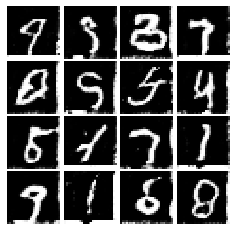


Iter: 5500/17187, D: -6.468, G:-1.041, time:1418.785034418106 sec)
Iter: 5520/17187, D: -9.451, G:-6.871, time:1423.2986743450165 sec)
Iter: 5540/17187, D: -12.11, G:-11.71, time:1427.835523366928 sec)
Iter: 5560/17187, D: -15.67, G:-29.32, time:1432.3844351768494 sec)
Iter: 5580/17187, D: -0.7309, G:-17.11, time:1436.9626696109772 sec)
Iter: 5600/17187, D: -0.3839, G:-21.85, time:1441.496595621109 sec)
Iter: 5620/17187, D: -0.6658, G:-31.37, time:1446.028383731842 sec)
Iter: 5640/17187, D: -0.6715, G:-35.32, time:1450.5557734966278 sec)
Iter: 5660/17187, D: -1.061, G:-36.75, time:1455.1309027671814 sec)
Iter: 5680/17187, D: -0.844, G:-38.1, time:1459.6642560958862 sec)
Iter: 5700/17187, D: -1.687, G:-37.08, time:1464.2189819812775 sec)
Iter: 5720/17187, D: -1.814, G:-38.35, time:1468.8235986232758 sec)
Iter: 5740/17187, D: -1.396, G:-37.97, time:1473.3774778842926 sec)


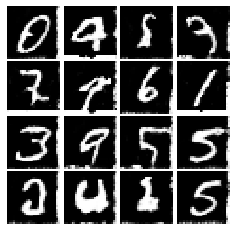


Iter: 5760/17187, D: -2.26, G:-38.86, time:1478.856683731079 sec)
Iter: 5780/17187, D: -2.049, G:-38.61, time:1483.4103479385376 sec)
Iter: 5800/17187, D: -1.827, G:-39.96, time:1488.0045392513275 sec)
Iter: 5820/17187, D: -2.316, G:-40.93, time:1492.550154209137 sec)
Iter: 5840/17187, D: -2.598, G:-39.57, time:1497.0878992080688 sec)
Iter: 5860/17187, D: -1.956, G:-40.61, time:1501.6874487400055 sec)
Iter: 5880/17187, D: -2.991, G:-41.7, time:1506.2365605831146 sec)
Iter: 5900/17187, D: -1.729, G:-43.86, time:1510.7764353752136 sec)
Iter: 5920/17187, D: -2.539, G:-43.1, time:1515.3207802772522 sec)
Iter: 5940/17187, D: -2.887, G:-43.85, time:1519.9049618244171 sec)
Iter: 5960/17187, D: -3.123, G:-44.14, time:1524.45206284523 sec)
Iter: 5980/17187, D: -4.284, G:-44.2, time:1528.9951469898224 sec)


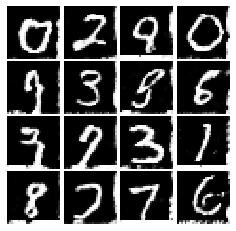


Iter: 6000/17187, D: -4.878, G:-44.55, time:1538.4038844108582 sec)
Iter: 6020/17187, D: -5.367, G:-46.76, time:1542.9537529945374 sec)
Iter: 6040/17187, D: -7.49, G:-45.34, time:1547.520896434784 sec)
Iter: 6060/17187, D: -8.753, G:-40.35, time:1552.1217839717865 sec)
Iter: 6080/17187, D: -10.95, G:-46.82, time:1556.6717126369476 sec)
Iter: 6100/17187, D: 2.697e+03, G:-7.253, time:1561.2251222133636 sec)
Iter: 6120/17187, D: -0.9655, G:-10.14, time:1565.774008512497 sec)
Iter: 6140/17187, D: -1.77, G:-11.68, time:1570.355474472046 sec)
Iter: 6160/17187, D: -2.228, G:-13.24, time:1574.9038472175598 sec)
Iter: 6180/17187, D: -2.587, G:-15.48, time:1579.453011751175 sec)
Iter: 6200/17187, D: -3.156, G:-17.27, time:1584.044551372528 sec)
Iter: 6220/17187, D: -4.225, G:-19.33, time:1588.5926077365875 sec)
Iter: 6240/17187, D: -6.603, G:-22.08, time:1593.1510462760925 sec)


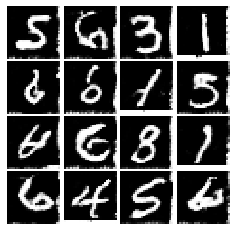


Iter: 6260/17187, D: -7.689, G:-22.94, time:1598.8165476322174 sec)
Iter: 6280/17187, D: 0.5503, G:-22.84, time:1603.4127237796783 sec)
Iter: 6300/17187, D: -7.889, G:-21.63, time:1607.9662947654724 sec)
Iter: 6320/17187, D: -14.6, G:-23.99, time:1612.5303754806519 sec)
Iter: 6340/17187, D: -12.23, G:-30.75, time:1617.0791969299316 sec)
Iter: 6360/17187, D: -3.131, G:-34.85, time:1621.6794924736023 sec)
Iter: 6380/17187, D: -15.16, G:-35.97, time:1626.2144660949707 sec)
Iter: 6400/17187, D: -11.33, G:-25.96, time:1630.7704138755798 sec)
Iter: 6420/17187, D: -20.25, G:-24.53, time:1635.3832576274872 sec)
Iter: 6440/17187, D: -19.84, G:-17.54, time:1639.9160828590393 sec)
Iter: 6460/17187, D: -2.098, G:38.35, time:1644.4711709022522 sec)
Iter: 6480/17187, D: -1.904, G:38.0, time:1649.0435214042664 sec)


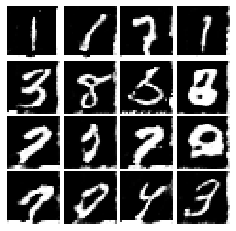


Iter: 6500/17187, D: -12.47, G:18.74, time:1658.4294109344482 sec)
Iter: 6520/17187, D: -9.705, G:20.39, time:1662.9807574748993 sec)
Iter: 6540/17187, D: -18.4, G:2.8, time:1667.5364019870758 sec)
Iter: 6560/17187, D: -19.41, G:-1.023, time:1672.128126859665 sec)
Iter: 6580/17187, D: -16.07, G:-18.38, time:1676.6924962997437 sec)
Iter: 6600/17187, D: -19.46, G:-7.165, time:1681.24969124794 sec)
Iter: 6620/17187, D: -33.59, G:-30.24, time:1685.8723533153534 sec)
Iter: 6640/17187, D: -10.47, G:-35.7, time:1690.4450812339783 sec)
Iter: 6660/17187, D: -24.66, G:-54.22, time:1694.9995625019073 sec)
Iter: 6680/17187, D: -22.17, G:-44.35, time:1699.555249452591 sec)
Iter: 6700/17187, D: -27.59, G:-34.3, time:1704.1612951755524 sec)
Iter: 6720/17187, D: -39.05, G:-72.74, time:1708.6991641521454 sec)
Iter: 6740/17187, D: -38.86, G:-67.27, time:1713.271028995514 sec)


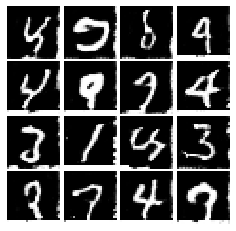


Iter: 6760/17187, D: -38.16, G:-16.9, time:1718.773217201233 sec)
Iter: 6780/17187, D: -44.11, G:-31.65, time:1723.3405866622925 sec)
Iter: 6800/17187, D: -7.089, G:-15.2, time:1727.8885431289673 sec)
Iter: 6820/17187, D: -29.69, G:-44.49, time:1732.4464185237885 sec)
Iter: 6840/17187, D: -34.92, G:-38.55, time:1737.0516345500946 sec)
Iter: 6860/17187, D: -39.18, G:-14.14, time:1741.6166610717773 sec)
Iter: 6880/17187, D: -46.67, G:38.8, time:1746.1637754440308 sec)
Iter: 6900/17187, D: -19.07, G:-38.69, time:1750.7027859687805 sec)
Iter: 6920/17187, D: -40.62, G:-39.94, time:1755.3101863861084 sec)
Iter: 6940/17187, D: -46.88, G:-24.55, time:1759.8758096694946 sec)
Iter: 6960/17187, D: -50.74, G:-29.91, time:1764.4433166980743 sec)
Iter: 6980/17187, D: -72.13, G:-110.7, time:1769.0460278987885 sec)


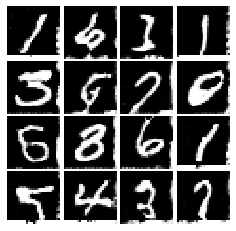


Iter: 7000/17187, D: -81.8, G:-4.468, time:1778.4175264835358 sec)
Iter: 7020/17187, D: -57.88, G:-12.22, time:1782.984563112259 sec)
Iter: 7040/17187, D: -54.88, G:-60.46, time:1787.5844719409943 sec)
Iter: 7060/17187, D: -52.86, G:-62.27, time:1792.1531853675842 sec)
Iter: 7080/17187, D: -72.53, G:-64.42, time:1796.7137835025787 sec)
Iter: 7100/17187, D: -79.4, G:-44.49, time:1801.3119592666626 sec)
Iter: 7120/17187, D: -87.84, G:-85.58, time:1805.8573331832886 sec)
Iter: 7140/17187, D: -90.42, G:-29.27, time:1810.416764497757 sec)
Iter: 7160/17187, D: -79.7, G:-20.8, time:1814.9638178348541 sec)
Iter: 7180/17187, D: -56.12, G:3.706, time:1819.563796043396 sec)
Iter: 7200/17187, D: -49.88, G:-85.86, time:1824.1172482967377 sec)
Iter: 7220/17187, D: -87.4, G:0.6989, time:1828.6959557533264 sec)
Iter: 7240/17187, D: -76.01, G:2.401, time:1833.2420647144318 sec)


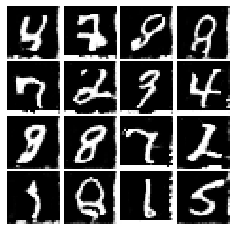


Iter: 7260/17187, D: -103.9, G:93.09, time:1838.7312805652618 sec)
Iter: 7280/17187, D: -101.6, G:-34.09, time:1843.2964553833008 sec)
Iter: 7300/17187, D: -88.38, G:42.7, time:1847.8518562316895 sec)
Iter: 7320/17187, D: -91.6, G:-0.1029, time:1852.4838542938232 sec)
Iter: 7340/17187, D: -95.34, G:-130.3, time:1857.048657655716 sec)
Iter: 7360/17187, D: -110.8, G:-44.5, time:1861.611353635788 sec)
Iter: 7380/17187, D: -106.3, G:-135.0, time:1866.1767897605896 sec)
Iter: 7400/17187, D: -112.7, G:-91.95, time:1870.7923257350922 sec)
Iter: 7420/17187, D: -106.7, G:-125.6, time:1875.351814031601 sec)
Iter: 7440/17187, D: -73.17, G:-30.8, time:1879.9208738803864 sec)
Iter: 7460/17187, D: -75.73, G:84.54, time:1884.5143930912018 sec)
Iter: 7480/17187, D: -94.1, G:-88.07, time:1889.0772066116333 sec)


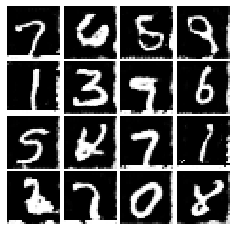


Iter: 7500/17187, D: -148.1, G:-115.5, time:1898.610577583313 sec)
Iter: 7520/17187, D: -138.0, G:-176.6, time:1903.2274103164673 sec)
Iter: 7540/17187, D: 2.952e+03, G:-242.6, time:1907.7961149215698 sec)
Iter: 7560/17187, D: -73.88, G:-78.49, time:1912.363377571106 sec)
Iter: 7580/17187, D: -81.74, G:16.39, time:1916.9377274513245 sec)
Iter: 7600/17187, D: -88.64, G:93.18, time:1921.5515251159668 sec)
Iter: 7620/17187, D: -75.68, G:11.82, time:1926.1208419799805 sec)
Iter: 7640/17187, D: -113.4, G:-91.68, time:1930.678569316864 sec)
Iter: 7660/17187, D: -115.9, G:-12.48, time:1935.2940881252289 sec)
Iter: 7680/17187, D: -112.1, G:14.19, time:1939.8423206806183 sec)
Iter: 7700/17187, D: -128.0, G:-151.3, time:1944.4131071567535 sec)
Iter: 7720/17187, D: -154.1, G:-35.76, time:1948.9812088012695 sec)
Iter: 7740/17187, D: -140.9, G:53.9, time:1953.5864391326904 sec)


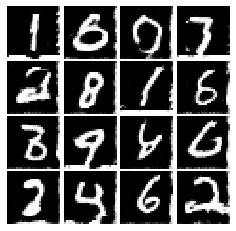


Iter: 7760/17187, D: -103.5, G:28.59, time:1959.011339187622 sec)
Iter: 7780/17187, D: -133.7, G:-70.92, time:1963.5673484802246 sec)
Iter: 7800/17187, D: -149.1, G:-146.3, time:1968.1686263084412 sec)
Iter: 7820/17187, D: -116.9, G:74.12, time:1972.7249357700348 sec)
Iter: 7840/17187, D: -78.94, G:-72.53, time:1977.3000359535217 sec)
Iter: 7860/17187, D: 2.755, G:-171.7, time:1981.8797183036804 sec)
Iter: 7880/17187, D: -76.48, G:-108.8, time:1986.490245103836 sec)
Iter: 7900/17187, D: -140.1, G:-57.09, time:1991.0364043712616 sec)
Iter: 7920/17187, D: -86.54, G:28.41, time:1995.607727766037 sec)
Iter: 7940/17187, D: -118.8, G:-71.64, time:2000.1667342185974 sec)
Iter: 7960/17187, D: -123.1, G:-181.5, time:2004.7802040576935 sec)
Iter: 7980/17187, D: -102.0, G:-42.3, time:2009.3340666294098 sec)


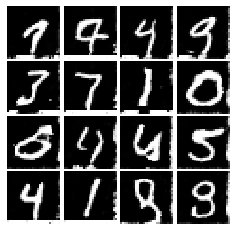


Iter: 8000/17187, D: -154.8, G:60.35, time:2018.752342224121 sec)
Iter: 8020/17187, D: -72.93, G:25.9, time:2023.3105819225311 sec)
Iter: 8040/17187, D: -137.3, G:25.41, time:2027.8635592460632 sec)
Iter: 8060/17187, D: -110.6, G:-78.06, time:2032.4178161621094 sec)
Iter: 8080/17187, D: -146.7, G:-66.07, time:2037.0369982719421 sec)
Iter: 8100/17187, D: -128.4, G:-92.44, time:2041.614605665207 sec)
Iter: 8120/17187, D: -131.3, G:-37.94, time:2046.1863105297089 sec)
Iter: 8140/17187, D: -162.6, G:-139.1, time:2050.73188495636 sec)
Iter: 8160/17187, D: -128.3, G:-116.7, time:2055.3290185928345 sec)
Iter: 8180/17187, D: -122.0, G:-159.3, time:2059.89537191391 sec)
Iter: 8200/17187, D: -148.5, G:53.62, time:2064.4529275894165 sec)
Iter: 8220/17187, D: -104.8, G:-103.7, time:2069.071078300476 sec)
Iter: 8240/17187, D: -133.4, G:-61.01, time:2073.634860754013 sec)


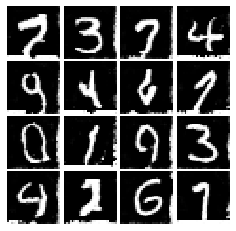


Iter: 8260/17187, D: -137.0, G:13.79, time:2079.0836215019226 sec)
Iter: 8280/17187, D: -111.9, G:-114.2, time:2083.6382942199707 sec)
Iter: 8300/17187, D: -89.54, G:-60.64, time:2088.2539603710175 sec)
Iter: 8320/17187, D: -160.8, G:116.7, time:2092.822798013687 sec)
Iter: 8340/17187, D: -98.11, G:-153.6, time:2097.3673791885376 sec)
Iter: 8360/17187, D: -113.1, G:35.11, time:2101.983413219452 sec)
Iter: 8380/17187, D: -136.3, G:-116.9, time:2106.538491010666 sec)
Iter: 8400/17187, D: -184.1, G:-172.4, time:2111.092633008957 sec)
Iter: 8420/17187, D: -137.7, G:-187.5, time:2115.6455297470093 sec)
Iter: 8440/17187, D: -121.2, G:-162.6, time:2120.252685546875 sec)
Iter: 8460/17187, D: -164.7, G:55.0, time:2124.798999786377 sec)
Iter: 8480/17187, D: -90.81, G:-121.4, time:2129.3431458473206 sec)


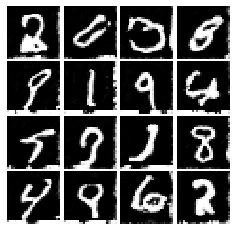


Iter: 8500/17187, D: -155.8, G:-105.6, time:2138.9146914482117 sec)
Iter: 8520/17187, D: -110.3, G:-110.8, time:2143.4703783988953 sec)
Iter: 8540/17187, D: -111.5, G:-31.55, time:2148.05407166481 sec)
Iter: 8560/17187, D: -144.2, G:-428.3, time:2152.6647851467133 sec)
Iter: 8580/17187, D: -149.9, G:-44.84, time:2157.2327160835266 sec)
Iter: 8600/17187, D: -116.5, G:-88.78, time:2161.801919221878 sec)
Iter: 8620/17187, D: -139.8, G:-151.8, time:2166.353532075882 sec)
Iter: 8640/17187, D: -177.5, G:-180.0, time:2170.938845872879 sec)
Iter: 8660/17187, D: -147.5, G:-221.0, time:2175.4917917251587 sec)
Iter: 8680/17187, D: -144.4, G:-236.9, time:2180.0385115146637 sec)
Iter: 8700/17187, D: -149.5, G:58.99, time:2184.6293864250183 sec)
Iter: 8720/17187, D: -136.0, G:125.4, time:2189.2001910209656 sec)
Iter: 8740/17187, D: -120.7, G:-48.54, time:2193.762729406357 sec)


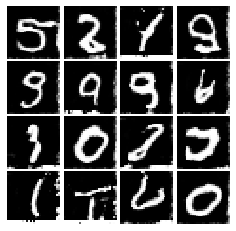


Iter: 8760/17187, D: -92.28, G:-76.63, time:2199.2183730602264 sec)
Iter: 8780/17187, D: -151.1, G:56.08, time:2203.812840938568 sec)
Iter: 8800/17187, D: -174.6, G:56.32, time:2208.364048242569 sec)
Iter: 8820/17187, D: -130.4, G:-85.7, time:2212.8991734981537 sec)
Iter: 8840/17187, D: -147.4, G:-247.0, time:2217.4574732780457 sec)
Iter: 8860/17187, D: -141.0, G:-57.76, time:2222.0304532051086 sec)
Iter: 8880/17187, D: -119.8, G:-220.2, time:2226.5749616622925 sec)
Iter: 8900/17187, D: -185.4, G:-204.7, time:2231.117162704468 sec)
Iter: 8920/17187, D: -137.7, G:-368.2, time:2235.6958882808685 sec)
Iter: 8940/17187, D: -116.6, G:-131.2, time:2240.23233962059 sec)
Iter: 8960/17187, D: -141.5, G:-64.15, time:2244.7698216438293 sec)
Iter: 8980/17187, D: -118.5, G:-219.9, time:2249.316939353943 sec)


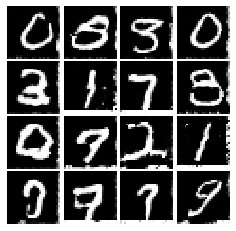


Iter: 9000/17187, D: -189.3, G:-47.0, time:2258.689375400543 sec)
Iter: 9020/17187, D: -148.1, G:-148.2, time:2263.2159790992737 sec)
Iter: 9040/17187, D: -147.6, G:-164.5, time:2267.744327068329 sec)
Iter: 9060/17187, D: -186.4, G:-54.88, time:2272.315000772476 sec)
Iter: 9080/17187, D: -160.5, G:195.2, time:2276.8424878120422 sec)
Iter: 9100/17187, D: -136.7, G:-47.86, time:2281.382321357727 sec)
Iter: 9120/17187, D: -144.1, G:-193.3, time:2285.9710054397583 sec)
Iter: 9140/17187, D: -141.1, G:-100.7, time:2290.4979889392853 sec)
Iter: 9160/17187, D: -66.89, G:-469.4, time:2295.0215232372284 sec)
Iter: 9180/17187, D: 203.8, G:-252.8, time:2299.563973426819 sec)
Iter: 9200/17187, D: -148.4, G:-228.9, time:2304.1470894813538 sec)
Iter: 9220/17187, D: -160.8, G:38.79, time:2308.6953299045563 sec)
Iter: 9240/17187, D: -161.2, G:-205.4, time:2313.245095014572 sec)


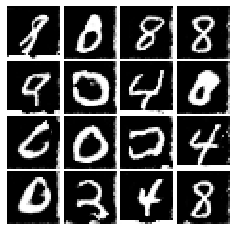


Iter: 9260/17187, D: -191.3, G:-366.8, time:2318.7338604927063 sec)
Iter: 9280/17187, D: -132.5, G:-191.7, time:2323.2604830265045 sec)
Iter: 9300/17187, D: -171.0, G:-180.2, time:2327.770385503769 sec)
Iter: 9320/17187, D: -163.6, G:225.0, time:2332.3165390491486 sec)
Iter: 9340/17187, D: -183.8, G:48.59, time:2336.8925080299377 sec)
Iter: 9360/17187, D: -189.0, G:-286.9, time:2341.429368019104 sec)
Iter: 9380/17187, D: -153.8, G:-238.3, time:2345.975734233856 sec)
Iter: 9400/17187, D: -137.4, G:-276.2, time:2350.564739704132 sec)
Iter: 9420/17187, D: -139.8, G:-88.84, time:2355.08517742157 sec)
Iter: 9440/17187, D: -172.8, G:20.33, time:2359.6151251792908 sec)
Iter: 9460/17187, D: -196.5, G:-351.9, time:2364.1539022922516 sec)
Iter: 9480/17187, D: 12.02, G:-127.6, time:2368.732076883316 sec)


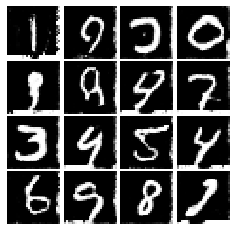


Iter: 9500/17187, D: -16.83, G:-20.25, time:2378.198699951172 sec)
Iter: 9520/17187, D: -117.2, G:-70.12, time:2382.741245985031 sec)
Iter: 9540/17187, D: -161.5, G:-393.6, time:2387.3258080482483 sec)
Iter: 9560/17187, D: -123.8, G:43.11, time:2391.8518357276917 sec)
Iter: 9580/17187, D: -188.4, G:-460.4, time:2396.3850088119507 sec)
Iter: 9600/17187, D: -133.7, G:150.4, time:2400.9451379776 sec)
Iter: 9620/17187, D: -200.6, G:49.02, time:2405.489474773407 sec)
Iter: 9640/17187, D: -144.1, G:-144.2, time:2410.0133922100067 sec)
Iter: 9660/17187, D: -156.1, G:-298.2, time:2414.543033838272 sec)
Iter: 9680/17187, D: -174.0, G:-226.9, time:2419.133936882019 sec)
Iter: 9700/17187, D: -133.9, G:-456.6, time:2423.683943271637 sec)
Iter: 9720/17187, D: -160.3, G:-223.2, time:2428.2200319767 sec)
Iter: 9740/17187, D: -122.0, G:-119.1, time:2432.773817062378 sec)


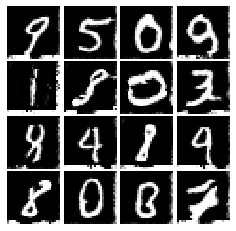


Iter: 9760/17187, D: -122.5, G:-332.1, time:2438.259797811508 sec)
Iter: 9780/17187, D: -183.1, G:-142.4, time:2442.814963579178 sec)
Iter: 9800/17187, D: -131.4, G:-143.0, time:2447.3582875728607 sec)
Iter: 9820/17187, D: -142.8, G:-90.74, time:2451.9677526950836 sec)
Iter: 9840/17187, D: -107.5, G:66.64, time:2456.532270669937 sec)
Iter: 9860/17187, D: -140.4, G:-511.3, time:2461.0935719013214 sec)
Iter: 9880/17187, D: -146.6, G:-144.3, time:2465.6468517780304 sec)
Iter: 9900/17187, D: -151.4, G:29.21, time:2470.258154630661 sec)
Iter: 9920/17187, D: -104.4, G:139.3, time:2474.8029747009277 sec)
Iter: 9940/17187, D: -180.6, G:-294.1, time:2479.355741739273 sec)
Iter: 9960/17187, D: -134.3, G:-162.2, time:2483.970941066742 sec)
Iter: 9980/17187, D: -146.7, G:-144.5, time:2488.5333120822906 sec)


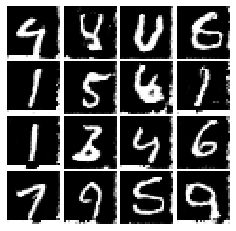


Iter: 10000/17187, D: -236.0, G:25.25, time:2497.883986234665 sec)
Iter: 10020/17187, D: -173.6, G:-288.9, time:2502.486733198166 sec)
Iter: 10040/17187, D: -191.7, G:-512.0, time:2507.0460534095764 sec)
Iter: 10060/17187, D: -135.3, G:-435.7, time:2511.6184346675873 sec)
Iter: 10080/17187, D: -88.19, G:-74.6, time:2516.1740658283234 sec)
Iter: 10100/17187, D: -143.8, G:-413.9, time:2520.764699459076 sec)
Iter: 10120/17187, D: -47.46, G:131.6, time:2525.3258213996887 sec)
Iter: 10140/17187, D: -164.4, G:-123.5, time:2529.8905487060547 sec)
Iter: 10160/17187, D: -176.3, G:73.73, time:2534.4807093143463 sec)
Iter: 10180/17187, D: -125.8, G:-231.8, time:2539.023550748825 sec)
Iter: 10200/17187, D: -181.0, G:-113.6, time:2543.5957469940186 sec)
Iter: 10220/17187, D: -148.9, G:-137.5, time:2548.157025575638 sec)
Iter: 10240/17187, D: -209.8, G:151.3, time:2552.774394273758 sec)


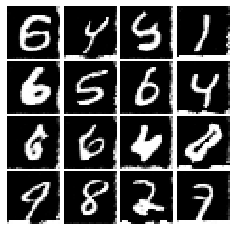


Iter: 10260/17187, D: -88.26, G:-358.6, time:2558.2212460041046 sec)
Iter: 10280/17187, D: -1.44, G:-67.95, time:2562.782965183258 sec)
Iter: 10300/17187, D: -166.5, G:-409.1, time:2567.3848965168 sec)
Iter: 10320/17187, D: -143.9, G:-159.2, time:2571.937423467636 sec)
Iter: 10340/17187, D: -90.54, G:-259.2, time:2576.5017380714417 sec)
Iter: 10360/17187, D: -70.49, G:-173.2, time:2581.0468850135803 sec)
Iter: 10380/17187, D: -86.74, G:-35.17, time:2585.6374621391296 sec)
Iter: 10400/17187, D: -125.4, G:-93.75, time:2590.201446056366 sec)
Iter: 10420/17187, D: -135.3, G:160.6, time:2594.7512624263763 sec)
Iter: 10440/17187, D: -206.7, G:-309.3, time:2599.29407453537 sec)
Iter: 10460/17187, D: -144.2, G:-402.7, time:2603.913609981537 sec)
Iter: 10480/17187, D: -133.3, G:-143.6, time:2608.4875054359436 sec)


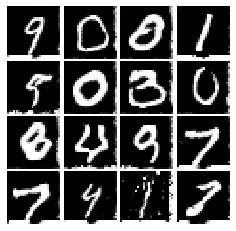


Iter: 10500/17187, D: -252.3, G:-220.7, time:2618.059305667877 sec)
Iter: 10520/17187, D: -145.5, G:-335.1, time:2622.592921972275 sec)
Iter: 10540/17187, D: -167.2, G:23.53, time:2627.1407153606415 sec)
Iter: 10560/17187, D: -171.7, G:-81.04, time:2631.718674659729 sec)
Iter: 10580/17187, D: -180.8, G:-294.1, time:2636.3264734745026 sec)
Iter: 10600/17187, D: -199.9, G:-391.1, time:2640.8885748386383 sec)
Iter: 10620/17187, D: -187.5, G:186.6, time:2645.451164007187 sec)
Iter: 10640/17187, D: -50.57, G:-330.3, time:2650.0101597309113 sec)
Iter: 10660/17187, D: -162.8, G:-294.4, time:2654.6110227108 sec)
Iter: 10680/17187, D: -127.4, G:-373.8, time:2659.1543352603912 sec)
Iter: 10700/17187, D: -154.5, G:-224.6, time:2663.7302668094635 sec)
Iter: 10720/17187, D: -62.23, G:292.5, time:2668.335824728012 sec)
Iter: 10740/17187, D: -107.0, G:-404.0, time:2672.8923995494843 sec)


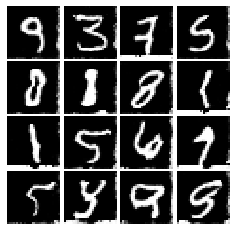


Iter: 10760/17187, D: -215.7, G:-197.0, time:2678.329108476639 sec)
Iter: 10780/17187, D: -145.5, G:-87.39, time:2682.8971638679504 sec)
Iter: 10800/17187, D: -153.9, G:87.74, time:2687.4980516433716 sec)
Iter: 10820/17187, D: -173.1, G:-322.5, time:2692.053339958191 sec)
Iter: 10840/17187, D: -183.1, G:-310.1, time:2696.617386341095 sec)
Iter: 10860/17187, D: -179.4, G:-94.13, time:2701.2240393161774 sec)
Iter: 10880/17187, D: -189.3, G:-153.5, time:2705.7715697288513 sec)
Iter: 10900/17187, D: -147.8, G:81.82, time:2710.321954011917 sec)
Iter: 10920/17187, D: -196.8, G:26.96, time:2714.8861768245697 sec)
Iter: 10940/17187, D: -254.1, G:-565.5, time:2719.4773852825165 sec)
Iter: 10960/17187, D: -148.5, G:-283.2, time:2724.0244331359863 sec)
Iter: 10980/17187, D: -154.3, G:-185.4, time:2728.588020324707 sec)


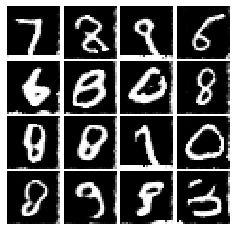


Iter: 11000/17187, D: -281.2, G:-60.57, time:2737.9884226322174 sec)
Iter: 11020/17187, D: -63.82, G:24.88, time:2742.549336194992 sec)
Iter: 11040/17187, D: -153.6, G:-252.7, time:2747.120996952057 sec)
Iter: 11060/17187, D: -11.88, G:1.667, time:2751.7402765750885 sec)
Iter: 11080/17187, D: -129.6, G:-249.7, time:2756.285328388214 sec)
Iter: 11100/17187, D: -134.5, G:-274.7, time:2760.8300857543945 sec)
Iter: 11120/17187, D: -119.3, G:-131.1, time:2765.391421318054 sec)
Iter: 11140/17187, D: -145.9, G:-314.7, time:2769.9960889816284 sec)
Iter: 11160/17187, D: -170.3, G:-166.1, time:2774.5457451343536 sec)
Iter: 11180/17187, D: -140.4, G:-15.68, time:2779.1091437339783 sec)
Iter: 11200/17187, D: -150.7, G:-28.71, time:2783.715837240219 sec)
Iter: 11220/17187, D: -102.1, G:-81.36, time:2788.2665100097656 sec)
Iter: 11240/17187, D: -179.7, G:-21.28, time:2792.835930109024 sec)


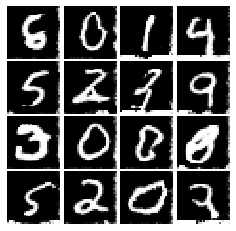


Iter: 11260/17187, D: -172.7, G:-52.95, time:2798.2802362442017 sec)
Iter: 11280/17187, D: -164.0, G:-60.22, time:2802.901034593582 sec)
Iter: 11300/17187, D: -173.3, G:-163.9, time:2807.459202528 sec)
Iter: 11320/17187, D: -165.7, G:50.32, time:2812.0276713371277 sec)
Iter: 11340/17187, D: -215.2, G:-271.9, time:2816.5832571983337 sec)
Iter: 11360/17187, D: -90.4, G:14.93, time:2821.196174144745 sec)
Iter: 11380/17187, D: -143.1, G:-284.0, time:2825.756369113922 sec)
Iter: 11400/17187, D: -184.0, G:-278.5, time:2830.3147027492523 sec)
Iter: 11420/17187, D: -197.6, G:-55.88, time:2834.922116279602 sec)
Iter: 11440/17187, D: 34.65, G:-108.7, time:2839.4778151512146 sec)
Iter: 11460/17187, D: 25.42, G:-92.19, time:2844.0490713119507 sec)
Iter: 11480/17187, D: -12.79, G:-68.54, time:2848.588838815689 sec)


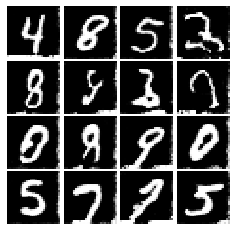


Iter: 11500/17187, D: -171.4, G:-6.53, time:2857.9890236854553 sec)
Iter: 11520/17187, D: -73.22, G:-88.35, time:2862.5317175388336 sec)
Iter: 11540/17187, D: -136.2, G:-118.3, time:2867.1373856067657 sec)
Iter: 11560/17187, D: -71.89, G:32.92, time:2871.687254667282 sec)
Iter: 11580/17187, D: -140.2, G:102.1, time:2876.243247270584 sec)
Iter: 11600/17187, D: -124.1, G:-223.3, time:2880.7974905967712 sec)
Iter: 11620/17187, D: 2.921, G:-26.98, time:2885.403895139694 sec)
Iter: 11640/17187, D: -20.76, G:-58.23, time:2889.945514678955 sec)
Iter: 11660/17187, D: -19.68, G:-51.8, time:2894.507097005844 sec)
Iter: 11680/17187, D: -111.9, G:-278.9, time:2899.057434797287 sec)
Iter: 11700/17187, D: -96.58, G:8.26, time:2903.666528224945 sec)
Iter: 11720/17187, D: -79.81, G:35.09, time:2908.2124683856964 sec)
Iter: 11740/17187, D: -135.2, G:21.67, time:2912.7692127227783 sec)


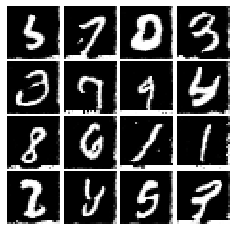


Iter: 11760/17187, D: -186.3, G:-236.5, time:2918.4150898456573 sec)
Iter: 11780/17187, D: -158.1, G:-287.2, time:2922.967190504074 sec)
Iter: 11800/17187, D: -118.7, G:-163.0, time:2927.5333354473114 sec)
Iter: 11820/17187, D: -151.5, G:-191.5, time:2932.093119621277 sec)
Iter: 11840/17187, D: -150.7, G:-133.0, time:2936.7050404548645 sec)
Iter: 11860/17187, D: -159.9, G:-450.9, time:2941.2752192020416 sec)
Iter: 11880/17187, D: -152.8, G:-127.8, time:2945.828784942627 sec)
Iter: 11900/17187, D: -164.9, G:-333.1, time:2950.4319458007812 sec)
Iter: 11920/17187, D: -116.2, G:-354.5, time:2954.9900147914886 sec)
Iter: 11940/17187, D: -102.5, G:193.4, time:2959.549215078354 sec)
Iter: 11960/17187, D: -154.9, G:-631.3, time:2964.1131501197815 sec)
Iter: 11980/17187, D: -175.9, G:-452.8, time:2968.715393781662 sec)


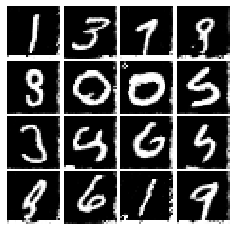


Iter: 12000/17187, D: -190.5, G:-126.2, time:2978.0902721881866 sec)
Iter: 12020/17187, D: -171.8, G:-103.7, time:2982.6365854740143 sec)
Iter: 12040/17187, D: -138.6, G:-84.14, time:2987.2340512275696 sec)
Iter: 12060/17187, D: -152.3, G:-239.1, time:2991.774313211441 sec)
Iter: 12080/17187, D: -187.6, G:-551.7, time:2996.3379554748535 sec)
Iter: 12100/17187, D: -158.4, G:212.4, time:3000.9458622932434 sec)
Iter: 12120/17187, D: -152.9, G:-175.9, time:3005.497576236725 sec)
Iter: 12140/17187, D: -164.3, G:-25.71, time:3010.0445461273193 sec)
Iter: 12160/17187, D: -154.9, G:-283.8, time:3014.595728635788 sec)
Iter: 12180/17187, D: -144.9, G:-151.6, time:3019.205219745636 sec)
Iter: 12200/17187, D: -117.4, G:-217.2, time:3023.7539579868317 sec)
Iter: 12220/17187, D: -180.4, G:-373.0, time:3028.3259973526 sec)
Iter: 12240/17187, D: -40.94, G:-121.8, time:3032.8745727539062 sec)


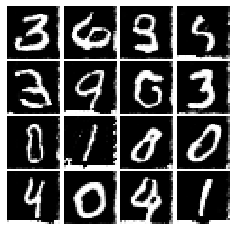


Iter: 12260/17187, D: -120.8, G:89.64, time:3038.3757004737854 sec)
Iter: 12280/17187, D: -111.2, G:-270.6, time:3042.927580356598 sec)
Iter: 12300/17187, D: -139.2, G:-299.7, time:3047.4870908260345 sec)
Iter: 12320/17187, D: -195.8, G:130.1, time:3052.082431793213 sec)
Iter: 12340/17187, D: -122.1, G:-5.913, time:3056.649720430374 sec)
Iter: 12360/17187, D: -172.9, G:-155.2, time:3061.205331802368 sec)
Iter: 12380/17187, D: -174.9, G:-379.0, time:3065.765277147293 sec)
Iter: 12400/17187, D: -154.1, G:-260.1, time:3070.3888516426086 sec)
Iter: 12420/17187, D: -128.9, G:5.604, time:3074.9458673000336 sec)
Iter: 12440/17187, D: -122.2, G:-205.4, time:3079.4900193214417 sec)
Iter: 12460/17187, D: -124.0, G:-210.3, time:3084.08638048172 sec)
Iter: 12480/17187, D: -175.5, G:-292.4, time:3088.6590490341187 sec)


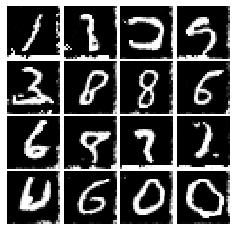


Iter: 12500/17187, D: -227.6, G:347.6, time:3098.0511384010315 sec)
Iter: 12520/17187, D: -128.8, G:-317.5, time:3102.6484451293945 sec)
Iter: 12540/17187, D: -172.6, G:-36.99, time:3107.221697330475 sec)
Iter: 12560/17187, D: -171.6, G:-176.8, time:3111.781958580017 sec)
Iter: 12580/17187, D: -158.0, G:-301.8, time:3116.365142583847 sec)
Iter: 12600/17187, D: -212.2, G:-193.2, time:3120.9907352924347 sec)
Iter: 12620/17187, D: -216.2, G:-99.39, time:3125.5539388656616 sec)
Iter: 12640/17187, D: -155.8, G:-111.7, time:3130.1215274333954 sec)
Iter: 12660/17187, D: -127.5, G:-18.25, time:3134.736901283264 sec)
Iter: 12680/17187, D: -147.5, G:-67.37, time:3139.306578397751 sec)
Iter: 12700/17187, D: -138.2, G:-67.48, time:3143.8664076328278 sec)
Iter: 12720/17187, D: -55.59, G:-330.6, time:3148.4317331314087 sec)
Iter: 12740/17187, D: -152.2, G:-366.8, time:3153.0474359989166 sec)


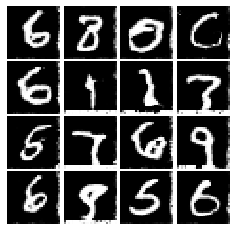


Iter: 12760/17187, D: -197.1, G:-191.3, time:3158.6581161022186 sec)
Iter: 12780/17187, D: -169.9, G:-583.2, time:3163.2187757492065 sec)
Iter: 12800/17187, D: -128.6, G:131.4, time:3167.829104423523 sec)
Iter: 12820/17187, D: -128.3, G:-36.72, time:3172.388977766037 sec)
Iter: 12840/17187, D: -229.3, G:-414.5, time:3176.9612953662872 sec)
Iter: 12860/17187, D: -45.31, G:-140.4, time:3181.5334627628326 sec)
Iter: 12880/17187, D: -118.8, G:-263.9, time:3186.1441617012024 sec)
Iter: 12900/17187, D: -185.7, G:-189.8, time:3190.7028777599335 sec)
Iter: 12920/17187, D: -180.3, G:-308.1, time:3195.2858848571777 sec)
Iter: 12940/17187, D: -127.5, G:-138.0, time:3199.85370016098 sec)
Iter: 12960/17187, D: -147.3, G:-662.9, time:3204.4539515972137 sec)
Iter: 12980/17187, D: -8.536, G:-28.44, time:3209.0276939868927 sec)


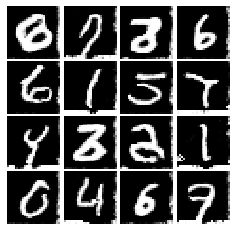


Iter: 13000/17187, D: -178.7, G:87.67, time:3218.4094235897064 sec)
Iter: 13020/17187, D: -128.6, G:-121.0, time:3222.948983192444 sec)
Iter: 13040/17187, D: -139.8, G:-286.0, time:3227.5071177482605 sec)
Iter: 13060/17187, D: -125.0, G:-144.4, time:3232.0706725120544 sec)
Iter: 13080/17187, D: -163.1, G:175.3, time:3236.6673057079315 sec)
Iter: 13100/17187, D: -175.8, G:-391.7, time:3241.232077598572 sec)
Iter: 13120/17187, D: -147.0, G:-88.55, time:3245.8010840415955 sec)
Iter: 13140/17187, D: -140.3, G:-310.2, time:3250.3979938030243 sec)
Iter: 13160/17187, D: -145.5, G:308.2, time:3254.9595198631287 sec)
Iter: 13180/17187, D: -150.9, G:-406.7, time:3259.5164663791656 sec)
Iter: 13200/17187, D: -131.6, G:-49.69, time:3264.0810120105743 sec)
Iter: 13220/17187, D: -113.2, G:313.9, time:3268.6859714984894 sec)
Iter: 13240/17187, D: -158.0, G:-11.27, time:3273.246952533722 sec)


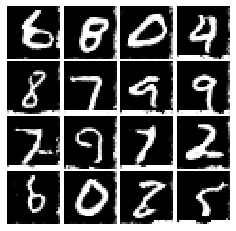


Iter: 13260/17187, D: -191.4, G:-341.0, time:3278.6922821998596 sec)
Iter: 13280/17187, D: -250.5, G:-467.6, time:3283.27294254303 sec)
Iter: 13300/17187, D: -230.4, G:-671.4, time:3287.883449077606 sec)
Iter: 13320/17187, D: -58.87, G:-441.3, time:3292.4508290290833 sec)
Iter: 13340/17187, D: 8.963e+03, G:-231.8, time:3297.0204315185547 sec)
Iter: 13360/17187, D: -22.18, G:-59.68, time:3301.6281213760376 sec)
Iter: 13380/17187, D: -72.54, G:-279.4, time:3306.18878698349 sec)
Iter: 13400/17187, D: -156.8, G:-3.42, time:3310.7447493076324 sec)
Iter: 13420/17187, D: -112.8, G:33.43, time:3315.3097484111786 sec)
Iter: 13440/17187, D: -129.1, G:-83.94, time:3319.918753862381 sec)
Iter: 13460/17187, D: -106.3, G:-16.71, time:3324.5154082775116 sec)
Iter: 13480/17187, D: -161.7, G:43.15, time:3329.080682039261 sec)


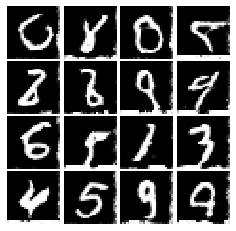


Iter: 13500/17187, D: -228.5, G:42.39, time:3338.4987473487854 sec)
Iter: 13520/17187, D: -59.2, G:-557.8, time:3343.040594816208 sec)
Iter: 13540/17187, D: -146.2, G:155.3, time:3347.6122794151306 sec)
Iter: 13560/17187, D: -204.1, G:134.4, time:3352.207268714905 sec)
Iter: 13580/17187, D: -125.0, G:-376.8, time:3356.7613999843597 sec)
Iter: 13600/17187, D: -165.7, G:-445.0, time:3361.317446947098 sec)
Iter: 13620/17187, D: -121.6, G:89.84, time:3365.892781972885 sec)
Iter: 13640/17187, D: -150.5, G:-212.9, time:3370.4944257736206 sec)
Iter: 13660/17187, D: -72.95, G:218.0, time:3375.045042514801 sec)
Iter: 13680/17187, D: -135.5, G:-87.13, time:3379.6010553836823 sec)
Iter: 13700/17187, D: -135.7, G:122.9, time:3384.218323945999 sec)
Iter: 13720/17187, D: -162.8, G:-142.1, time:3388.779960632324 sec)
Iter: 13740/17187, D: -113.7, G:-360.8, time:3393.365753173828 sec)


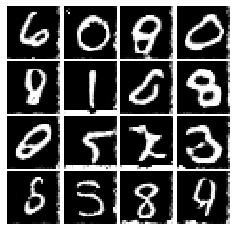


Iter: 13760/17187, D: -151.2, G:-130.1, time:3399.0143258571625 sec)
Iter: 13780/17187, D: -189.1, G:-257.2, time:3403.6333158016205 sec)
Iter: 13800/17187, D: -158.1, G:-309.9, time:3408.2001094818115 sec)
Iter: 13820/17187, D: -150.2, G:-365.7, time:3412.76814866066 sec)
Iter: 13840/17187, D: -149.7, G:131.5, time:3417.374390602112 sec)
Iter: 13860/17187, D: -122.6, G:-92.32, time:3421.9398844242096 sec)
Iter: 13880/17187, D: 54.4, G:-63.89, time:3426.50292468071 sec)
Iter: 13900/17187, D: -7.357, G:2.171, time:3431.0501008033752 sec)
Iter: 13920/17187, D: -66.15, G:-257.5, time:3435.6697750091553 sec)
Iter: 13940/17187, D: -83.34, G:-62.02, time:3440.242833375931 sec)
Iter: 13960/17187, D: -153.7, G:-105.5, time:3444.8144624233246 sec)
Iter: 13980/17187, D: -105.7, G:-465.6, time:3449.3721816539764 sec)


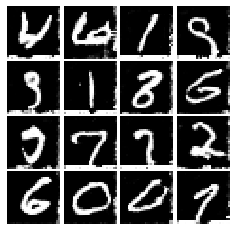


Iter: 14000/17187, D: 5.011, G:-112.5, time:3458.7801852226257 sec)
Iter: 14020/17187, D: -104.1, G:-250.5, time:3463.313438653946 sec)
Iter: 14040/17187, D: -79.61, G:-125.6, time:3467.9153389930725 sec)
Iter: 14060/17187, D: -113.6, G:-39.43, time:3472.4928917884827 sec)
Iter: 14080/17187, D: -86.71, G:-134.1, time:3477.0618522167206 sec)
Iter: 14100/17187, D: -72.49, G:-123.0, time:3481.6311297416687 sec)
Iter: 14120/17187, D: -137.4, G:-246.2, time:3486.2428352832794 sec)
Iter: 14140/17187, D: -146.4, G:-252.6, time:3490.8089866638184 sec)
Iter: 14160/17187, D: -141.9, G:-61.98, time:3495.366506576538 sec)
Iter: 14180/17187, D: -100.5, G:131.2, time:3499.9563159942627 sec)
Iter: 14200/17187, D: -117.1, G:-128.6, time:3504.55747795105 sec)
Iter: 14220/17187, D: -103.9, G:-205.4, time:3509.121810913086 sec)
Iter: 14240/17187, D: -108.5, G:20.95, time:3513.689177274704 sec)


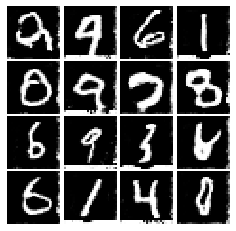


Iter: 14260/17187, D: -112.1, G:97.01, time:3519.182580471039 sec)
Iter: 14280/17187, D: -168.7, G:141.2, time:3523.7553446292877 sec)
Iter: 14300/17187, D: -124.4, G:-182.8, time:3528.3372309207916 sec)
Iter: 14320/17187, D: -139.9, G:234.8, time:3532.901324748993 sec)
Iter: 14340/17187, D: -110.1, G:-259.5, time:3537.512063741684 sec)
Iter: 14360/17187, D: -99.78, G:-62.73, time:3542.073345184326 sec)
Iter: 14380/17187, D: -158.2, G:-78.38, time:3546.6223287582397 sec)
Iter: 14400/17187, D: -109.3, G:-161.1, time:3551.2187838554382 sec)
Iter: 14420/17187, D: -120.2, G:-123.3, time:3555.797388076782 sec)
Iter: 14440/17187, D: -131.0, G:-264.7, time:3560.3637189865112 sec)
Iter: 14460/17187, D: 2.428e+03, G:124.1, time:3564.937998533249 sec)
Iter: 14480/17187, D: -115.9, G:-13.08, time:3569.5480604171753 sec)


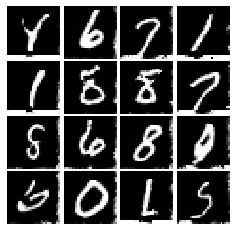


Iter: 14500/17187, D: -188.4, G:196.0, time:3578.92511343956 sec)
Iter: 14520/17187, D: -149.0, G:-178.2, time:3583.4854011535645 sec)
Iter: 14540/17187, D: -112.4, G:45.63, time:3588.08230304718 sec)
Iter: 14560/17187, D: -194.0, G:41.5, time:3592.639739513397 sec)
Iter: 14580/17187, D: 303.0, G:-44.73, time:3597.2029950618744 sec)
Iter: 14600/17187, D: 12.38, G:-23.42, time:3601.7981045246124 sec)
Iter: 14620/17187, D: 4.259, G:-30.47, time:3606.360278367996 sec)
Iter: 14640/17187, D: -1.254, G:20.92, time:3610.9126210212708 sec)
Iter: 14660/17187, D: -74.6, G:-188.1, time:3615.4513816833496 sec)
Iter: 14680/17187, D: -106.5, G:-110.9, time:3620.0706543922424 sec)
Iter: 14700/17187, D: -123.8, G:-101.8, time:3624.6259336471558 sec)
Iter: 14720/17187, D: -121.2, G:-107.5, time:3629.182832479477 sec)
Iter: 14740/17187, D: -128.4, G:47.08, time:3633.776580095291 sec)


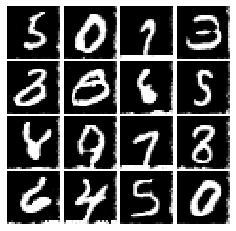


Iter: 14760/17187, D: -142.3, G:-261.1, time:3639.4082927703857 sec)
Iter: 14780/17187, D: -100.8, G:46.71, time:3643.9666216373444 sec)
Iter: 14800/17187, D: -128.8, G:-131.5, time:3648.5270643234253 sec)
Iter: 14820/17187, D: -117.5, G:38.92, time:3653.140479326248 sec)
Iter: 14840/17187, D: -154.5, G:-73.59, time:3657.6807198524475 sec)
Iter: 14860/17187, D: -104.3, G:6.744, time:3662.2241685390472 sec)
Iter: 14880/17187, D: -138.4, G:-125.2, time:3666.7787597179413 sec)
Iter: 14900/17187, D: -134.4, G:49.22, time:3671.388678073883 sec)
Iter: 14920/17187, D: -135.1, G:-358.8, time:3675.9522366523743 sec)
Iter: 14940/17187, D: -141.8, G:320.1, time:3680.5205352306366 sec)
Iter: 14960/17187, D: -162.2, G:-493.7, time:3685.1141424179077 sec)
Iter: 14980/17187, D: -67.71, G:127.4, time:3689.684767484665 sec)


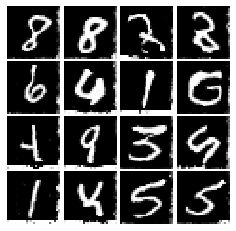


Iter: 15000/17187, D: -230.5, G:-20.04, time:3699.008721590042 sec)
Iter: 15020/17187, D: 43.22, G:-75.57, time:3703.6083550453186 sec)
Iter: 15040/17187, D: 23.84, G:-73.02, time:3708.1481623649597 sec)
Iter: 15060/17187, D: 5.365, G:-74.82, time:3712.6936922073364 sec)
Iter: 15080/17187, D: -2.69, G:-38.77, time:3717.252381801605 sec)
Iter: 15100/17187, D: -54.42, G:-160.3, time:3721.856155872345 sec)
Iter: 15120/17187, D: -90.4, G:107.7, time:3726.425754070282 sec)
Iter: 15140/17187, D: -111.0, G:-357.0, time:3730.981087207794 sec)
Iter: 15160/17187, D: -128.6, G:-204.0, time:3735.5832681655884 sec)
Iter: 15180/17187, D: -116.0, G:-144.7, time:3740.1328682899475 sec)
Iter: 15200/17187, D: -141.1, G:-27.76, time:3744.695681333542 sec)
Iter: 15220/17187, D: -134.1, G:-20.45, time:3749.2648510932922 sec)
Iter: 15240/17187, D: -151.4, G:156.5, time:3753.8793494701385 sec)


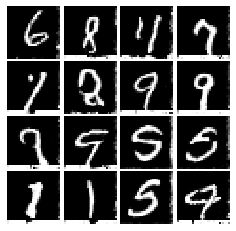


Iter: 15260/17187, D: -145.1, G:-63.48, time:3759.300960302353 sec)
Iter: 15280/17187, D: -125.7, G:216.3, time:3763.8476049900055 sec)
Iter: 15300/17187, D: -133.6, G:-272.1, time:3768.4518945217133 sec)
Iter: 15320/17187, D: -119.9, G:-227.0, time:3772.9995300769806 sec)
Iter: 15340/17187, D: -152.1, G:63.48, time:3777.554441213608 sec)
Iter: 15360/17187, D: -102.2, G:-115.8, time:3782.129246711731 sec)
Iter: 15380/17187, D: -111.2, G:-260.2, time:3786.74241399765 sec)
Iter: 15400/17187, D: -118.8, G:-288.6, time:3791.3070435523987 sec)
Iter: 15420/17187, D: -173.0, G:9.994, time:3795.8637976646423 sec)
Iter: 15440/17187, D: -151.6, G:-97.71, time:3800.476840734482 sec)
Iter: 15460/17187, D: -67.58, G:-511.4, time:3805.0373327732086 sec)
Iter: 15480/17187, D: -169.8, G:-174.0, time:3809.588703393936 sec)


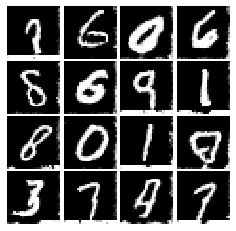


Iter: 15500/17187, D: 11.9, G:-67.73, time:3818.996033668518 sec)
Iter: 15520/17187, D: 0.6364, G:-36.09, time:3823.5487904548645 sec)
Iter: 15540/17187, D: -8.992, G:-38.44, time:3828.1059849262238 sec)
Iter: 15560/17187, D: -93.23, G:-141.1, time:3832.6670558452606 sec)
Iter: 15580/17187, D: -104.5, G:-260.6, time:3837.282220363617 sec)
Iter: 15600/17187, D: -124.1, G:-142.7, time:3841.8330702781677 sec)
Iter: 15620/17187, D: -105.3, G:-16.72, time:3846.3673610687256 sec)
Iter: 15640/17187, D: -111.4, G:-57.25, time:3850.969468832016 sec)
Iter: 15660/17187, D: -112.9, G:-93.08, time:3855.50768494606 sec)
Iter: 15680/17187, D: -147.7, G:-84.89, time:3860.065537214279 sec)
Iter: 15700/17187, D: -121.7, G:-407.1, time:3864.6353034973145 sec)
Iter: 15720/17187, D: -3.934, G:-97.03, time:3869.239329099655 sec)
Iter: 15740/17187, D: -130.2, G:19.09, time:3873.793887615204 sec)


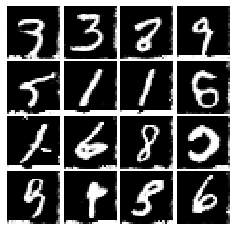


Iter: 15760/17187, D: -167.4, G:196.5, time:3879.244476556778 sec)
Iter: 15780/17187, D: -188.4, G:-489.0, time:3883.813771724701 sec)
Iter: 15800/17187, D: -183.4, G:17.89, time:3888.4328532218933 sec)
Iter: 15820/17187, D: -132.8, G:-316.9, time:3892.99675488472 sec)
Iter: 15840/17187, D: 45.87, G:-83.85, time:3897.5574312210083 sec)
Iter: 15860/17187, D: 23.76, G:-69.24, time:3902.1662487983704 sec)
Iter: 15880/17187, D: -8.075, G:-36.33, time:3906.714786052704 sec)
Iter: 15900/17187, D: -95.29, G:48.67, time:3911.2585792541504 sec)
Iter: 15920/17187, D: -108.9, G:104.7, time:3915.8144495487213 sec)
Iter: 15940/17187, D: -124.7, G:-192.2, time:3920.4135839939117 sec)
Iter: 15960/17187, D: -92.07, G:52.94, time:3924.9648971557617 sec)
Iter: 15980/17187, D: -115.4, G:-61.77, time:3929.516037940979 sec)


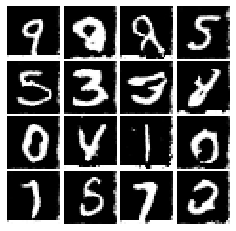


Iter: 16000/17187, D: 20.48, G:-61.04, time:3939.1465220451355 sec)
Iter: 16020/17187, D: -43.24, G:0.1409, time:3943.715800523758 sec)
Iter: 16040/17187, D: -74.11, G:169.4, time:3948.277581214905 sec)
Iter: 16060/17187, D: -114.2, G:-163.8, time:3952.8890640735626 sec)
Iter: 16080/17187, D: -176.5, G:-550.7, time:3957.4502577781677 sec)
Iter: 16100/17187, D: -160.4, G:-20.11, time:3962.0095081329346 sec)
Iter: 16120/17187, D: -62.83, G:-111.0, time:3966.5716264247894 sec)
Iter: 16140/17187, D: -91.07, G:41.63, time:3971.176406621933 sec)
Iter: 16160/17187, D: -77.26, G:136.6, time:3975.7362892627716 sec)
Iter: 16180/17187, D: -129.8, G:-355.5, time:3980.295944929123 sec)
Iter: 16200/17187, D: -156.9, G:25.93, time:3984.9134135246277 sec)
Iter: 16220/17187, D: -138.7, G:230.3, time:3989.4771494865417 sec)
Iter: 16240/17187, D: -89.9, G:259.3, time:3994.0418725013733 sec)


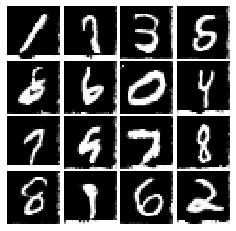


Iter: 16260/17187, D: -146.5, G:235.5, time:3999.483524799347 sec)
Iter: 16280/17187, D: -93.89, G:-76.19, time:4004.1067011356354 sec)
Iter: 16300/17187, D: -141.5, G:-211.5, time:4008.6697793006897 sec)
Iter: 16320/17187, D: -126.7, G:-179.2, time:4013.219158411026 sec)
Iter: 16340/17187, D: -153.2, G:-343.4, time:4017.8377707004547 sec)
Iter: 16360/17187, D: -172.1, G:-234.8, time:4022.4021425247192 sec)
Iter: 16380/17187, D: -182.8, G:-250.2, time:4026.955156326294 sec)
Iter: 16400/17187, D: 7.655, G:-89.89, time:4031.5030102729797 sec)
Iter: 16420/17187, D: -3.835, G:-79.91, time:4036.11528468132 sec)
Iter: 16440/17187, D: -71.87, G:-307.6, time:4040.6771972179413 sec)
Iter: 16460/17187, D: -131.0, G:38.74, time:4045.2300050258636 sec)
Iter: 16480/17187, D: -139.4, G:-189.5, time:4049.7973940372467 sec)


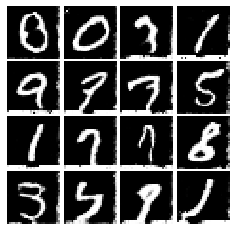


Iter: 16500/17187, D: -164.5, G:189.0, time:4059.1812319755554 sec)
Iter: 16520/17187, D: -179.5, G:-15.25, time:4063.72988653183 sec)
Iter: 16540/17187, D: -157.4, G:-302.9, time:4068.3240563869476 sec)
Iter: 16560/17187, D: -142.0, G:-251.2, time:4072.881441116333 sec)
Iter: 16580/17187, D: -170.3, G:-231.6, time:4077.4529390335083 sec)
Iter: 16600/17187, D: -178.2, G:136.5, time:4082.0069222450256 sec)
Iter: 16620/17187, D: -24.2, G:-17.45, time:4086.6169571876526 sec)
Iter: 16640/17187, D: -102.8, G:-136.4, time:4091.1652426719666 sec)
Iter: 16660/17187, D: -191.1, G:-226.5, time:4095.724874019623 sec)
Iter: 16680/17187, D: -142.6, G:-129.3, time:4100.306710720062 sec)
Iter: 16700/17187, D: -152.3, G:2.31, time:4104.922371149063 sec)
Iter: 16720/17187, D: -151.1, G:270.8, time:4109.48671913147 sec)
Iter: 16740/17187, D: -113.1, G:-97.3, time:4114.024959802628 sec)


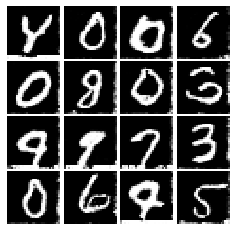


Iter: 16760/17187, D: -157.2, G:368.2, time:4119.52974152565 sec)
Iter: 16780/17187, D: -142.0, G:-29.71, time:4124.093006372452 sec)
Iter: 16800/17187, D: -126.7, G:-313.0, time:4128.622322797775 sec)
Iter: 16820/17187, D: -117.0, G:-121.8, time:4133.182297229767 sec)
Iter: 16840/17187, D: -141.6, G:9.221, time:4137.804030895233 sec)
Iter: 16860/17187, D: -139.4, G:-214.1, time:4142.372121334076 sec)
Iter: 16880/17187, D: -154.1, G:-145.3, time:4146.921561717987 sec)
Iter: 16900/17187, D: -112.6, G:13.89, time:4151.536310434341 sec)
Iter: 16920/17187, D: -155.9, G:-189.1, time:4156.088376998901 sec)
Iter: 16940/17187, D: -163.7, G:-235.7, time:4160.631245136261 sec)
Iter: 16960/17187, D: -112.2, G:-129.3, time:4165.180337190628 sec)
Iter: 16980/17187, D: -157.7, G:-133.2, time:4169.792366027832 sec)


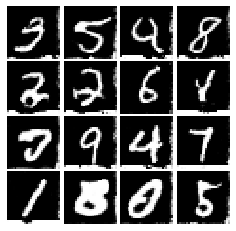


Iter: 17000/17187, D: -260.3, G:-344.9, time:4179.3392543792725 sec)
Iter: 17020/17187, D: -122.8, G:70.01, time:4183.894466638565 sec)
Iter: 17040/17187, D: -155.4, G:72.96, time:4188.495817184448 sec)
Iter: 17060/17187, D: -136.8, G:86.86, time:4193.0476603508 sec)
Iter: 17080/17187, D: -188.2, G:205.1, time:4197.617185592651 sec)
Iter: 17100/17187, D: -184.0, G:-149.7, time:4202.222805976868 sec)
Iter: 17120/17187, D: -174.8, G:-6.0, time:4206.77241563797 sec)
Iter: 17140/17187, D: 14.09, G:-112.3, time:4211.334735870361 sec)
Iter: 17160/17187, D: -120.4, G:-224.9, time:4215.893193721771 sec)
Iter: 17180/17187, D: -139.5, G:-98.8, time:4220.500658988953 sec)
Final images


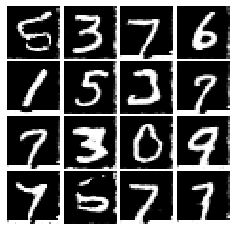

In [5]:
##################   WGAN

def discriminator_WGAN(x):
    with tf.variable_scope('discriminator'):
        # TODO: implement architecture
        init = tf.contrib.layers.xavier_initializer()
        x = tf.reshape(x,[-1,28,28,1])
        conv1 = tf.layers.conv2d(x, filters=64, padding='VALID', kernel_size=4, strides=2,
                                   activation=lambda x: tf.nn.leaky_relu(x,0.01),kernel_initializer=init, name = 'conv1')
        conv2 = tf.layers.conv2d(conv1, filters=128, padding='VALID', kernel_size=4, strides=2,
                                   activation=lambda x: tf.nn.leaky_relu(x,0.01),kernel_initializer=init, name = 'conv2')
        bn3 = tf.layers.batch_normalization(conv2, training=True,name='bn3')
        
        flatten = tf.contrib.layers.flatten(bn3)
        
        fc4 = tf.layers.dense(flatten, units=1024 , activation=lambda x: tf.nn.leaky_relu(x,0.01) ,kernel_initializer=init,name='fc4')
        fc5 = tf.layers.dense(fc4, units=1 , activation= None ,kernel_initializer=init,name='fc5')
        logits = fc5
        return logits

def generator_DCGAN(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        fc1 = tf.layers.dense(z, units=1024 , activation=tf.nn.relu ,name='fc1')
        bn2 =  tf.layers.batch_normalization(fc1, training=True,name='bn2')
        fc3 = tf.layers.dense(bn2, units=7*7*128 , activation=tf.nn.relu ,name='fc3')
        bn4 =  tf.layers.batch_normalization(fc3, training=True,name='bn4')
        to_img =  tf.reshape(bn4,[-1,7,7,128])
        deconv5 = tf.layers.conv2d_transpose(to_img,padding='SAME',filters=64,kernel_size=4, strides=2,
                                             activation=tf.nn.relu,name='deconv5')
        bn6 =  tf.layers.batch_normalization(deconv5, training=True,name='bn6')
        deconv7 = tf.layers.conv2d_transpose(bn6,padding='SAME',filters=1,kernel_size=4, strides=2,
                                             activation=tf.nn.tanh,name='deconv7')        
        img = deconv7
        return img 

      
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = - tf.reduce_mean(logits_real) + tf.reduce_mean(logits_fake)
    G_loss = - tf.reduce_mean(logits_fake)

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform([batch_size,1], minval=0.0, maxval=1.0)
    x_hat = eps*x+(1-eps)*G_sample

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = tf.gradients(discriminator_WGAN(x_hat), x_hat)

    grad_norm = tf.norm(grad_D_x_hat[0], axis=1, ord='euclidean')
    grad_pen = tf.reduce_mean(tf.square(grad_norm-1))

    D_loss += lam*grad_pen

    return D_loss, G_loss
      
# a giant helper function
def run_a_wgan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=20, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    s = time.time()
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        
        if it < 25 or it % 500 == 0:
            citers = 100
        else:
            citers = 5
        for j in range(citers):
            minibatch,minbatch_y = mnist.train.next_batch(batch_size)
            _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
            
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}/{}, D: {:.4}, G:{:.4}, time:{} sec)'.format(it,max_iter,D_loss_curr,G_loss_curr,time.time()-s))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()      
      
      
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = tf.reshape(generator_DCGAN(z),[batch_size,-1])

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator_WGAN(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator_WGAN(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')


with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_wgan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=40)

